<b>TERMINAR:</b>

* explicar modelos
* melhorar graficos (titulos, etc.)
* retirar comentários do boruta quando for postar no github
* colorir dataframe de métricas dos modelos
* explicação das funções criadas

# RESUMO

## Sobre o projeto

Previsão de vendas das próximas 6 semanas (42 dias).

O formato de entrega será o valor total das vendas no final dessas 6 semanas (2 colunas: código da loja e valor total das vendas previsto) e com checagem pelo smartphone (verificação da loja desejada, seu valor de vendas e o comportamento das vendas durante essas 6 semanas).

Por questão meramente didática, o notebook foi feito de forma linear, contendo tópicos que poderiam ser subseções de outros tópicos, apenas para que a explicação ficasse mais detalhada.

## Dicionário dos dados

Data fields
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* **Id** - an Id that represents a (Store, Date) duple within the test set
* **Store** - a unique Id for each store
* **Sales** - the turnover for any given day (this is what you are predicting)
* **Customers** - the number of customers on a given day
* **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
* **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
* **StoreType** - differentiates between 4 different store models: a, b, c, d
* **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
* **CompetitionDistance** - distance in meters to the nearest competitor store
* **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
* **Promo** - indicates whether a store is running a promo on that day
* **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
* **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# IMPORTS

In [1]:
# importações de pacotes
import pandas as pd
import numpy as np
import datetime
from math import isnan
import inflection
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import warnings
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from boruta import BorutaPy
warnings.filterwarnings('ignore')

## Carregamento dos dados

In [2]:
# leitura dos dados
# informações de vendas (train)
# informações das lojas (store)
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

In [3]:
df_sales_raw.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
# head
df_store_raw.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
# unir os 2 datasets (esquerda, coluna "store" de chave)
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

In [6]:
df_raw.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Funções auxiliares

In [7]:
def robust_scaler(df, lista_variaveis):
    for var in lista_variaveis:
        df[var] = rs.fit_transform(df[[var]].values)

In [8]:
def min_max_scaler(df, lista_variaveis):
    for var in lista_variaveis:
        df[var] = mms.fit_transform(df[[var]].values)

In [9]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

In [10]:
def ml_error(nome_modelo, y_teste, yhat):
    mae = mean_absolute_error(y_teste, yhat)
    mape = mean_absolute_percentage_error(y_teste, yhat)
    rmse = np.sqrt(mean_squared_error(y_teste, yhat))
    
    return pd.DataFrame({ 'Modelo': nome_modelo,
                          'mae': mae,
                          'mape': mape,
                          'rmse': rmse}, index = [0])

In [11]:
def cross_validation_series_temporais(kfold, X_treino, nome_modelo, modelo, verbose = False):
    mae_lista = []
    mape_lista = []
    rmse_lista = []
    for k in reversed(range(1, kfold + 1)):
        
        if verbose:
            print(f'Número do KFold: {k}')
        data_inicio_validacao = X_treino['date'].max() - datetime.timedelta(days = k*6*7)
        data_fim_validacao = X_treino['date'].max() - datetime.timedelta(days = (k-1)*6*7)
        
        treino = X_treino[X_treino['date'] < data_inicio_validacao]
        validacao = X_treino[(X_treino['date'] >= data_inicio_validacao) & (X_treino['date'] <= data_fim_validacao)]
        
        # separar os dados de treino
        xtreino = treino.drop(['date', 'sales'], axis = 1)
        ytreino = treino['sales']

        # separar os dados de validação (acima ou igual a data de inicio e abaixo ou igual a data de fim)
        xvalidacao = validacao.drop(['date', 'sales'], axis = 1)
        yvalidacao = validacao['sales']
        
        modelo = modelo         
        modelo.fit(xtreino, ytreino)
        yhat = modelo.predict(xvalidacao)
        
        resultado = ml_error(nome_modelo, np.expm1(yvalidacao), np.expm1(yhat))
        mae_lista.append(resultado['mae'])
        mape_lista.append(resultado['mape'])
        rmse_lista.append(resultado['rmse'])
        
    return (pd.DataFrame(
            {'Nome do modelo': nome_modelo,
             'MAE': np.round(np.mean(mae_lista), 2).astype('str') + ' + ou - ' + np.round(np.std(mae_lista), 2).astype('str'),
             'MAPE': np.round(np.mean(mape_lista), 2).astype('str') + ' + ou - ' + np.round(np.std(mape_lista), 2).astype('str'),
             'RSME': np.round(np.mean(rmse_lista), 2).astype('str') + ' + ou - ' + np.round(np.std(rmse_lista), 2).astype('str')},
            index = [0]))

# DESCRIÇÃO DOS DADOS

## Renomeando as colunas

In [12]:
# criar cópia do df
df1 = df_raw.copy()

In [13]:
# verificar colunas e seus nomes
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [14]:
# criar lista com os nomes das colunas
cols_atuais = df1.columns

In [15]:
# criar função lambda "snakecase" para passar tudo para minuscula
snakecase = lambda x: inflection.underscore(x)

In [16]:
# utilizar map
cols_novas = list(map(snakecase, cols_atuais))

In [17]:
#renomear
df1.columns = cols_novas

## Dimensão dos dados

In [18]:
# número de linhas e colunas
print(f'Número de linhas: {df1.shape[0]}')
print(f'Número de colunas: {df1.shape[1]}')

Número de linhas: 1017209
Número de colunas: 18


## Tipos de dados e conversão de "date"

In [19]:
# tipos de dados
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [20]:
# converter "date" para o tipo "date"
df1['date'] = pd.to_datetime(df1['date'])

In [21]:
# tipos de dados
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Checagem de valores NA

In [22]:
# somas das colunas que possuam pelo menos 1 valor NA
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Preenchendo dados nulos

In [23]:
#competition_distance              2642
#competition_open_since_month    323348
#competition_open_since_year     323348                               
#promo2_since_week               508031
#promo2_since_year               508031
#promo_interval                  508031

**competition_distance**: se há valor NA, provavelmente não há competidor mais próximo (não há competição).

Uma solução seria preencher os campos nulos com valores muito mais altos do que o valor máximo da coluna, pois assim sinalizamos que não há competição.

In [24]:
# verificar valor máximo da coluna
df1.competition_distance.max()

75860.0

In [25]:
# verificar com isnan se a linha da coluna definida "é nula"
# caso a linha seja "nula", vamos preenche-la com o valor 2000000. Senão, retorna o valor da linha
# usar lambda e apply e apenas na coluna
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if isnan(x) else x)

**competition_open_since_month**: talvez existam 2 razões para essa coluna estar vazia: não há competidor mais próximo, então não há data de abertura para ele, ou há competidor mais próximo e não se sabe quando abriu.

Podemos preencher os valores NA extraindo o mês da própria linha (cada linha representa uma venda em uma data, em uma loja). Isso pode ser feito já pensando na etapa de feature engineering, pois há colunas que são importantes para mostrarem um comportamento ao longo do tempo (nesse caso, sobre a competição ao longo do tempo). 

A substituição acima será feita com o valor do mês da coluna "date"se o valor da coluna for nulo. Senão, será retornado o valor que já existe.

Caso essa solução não funcione, podemos voltar e alterá-la (graças ao CRISP-DS).

In [26]:
# aplicar apenas nas colunas
# como serão utilizadas mais de uma coluna, precisamos especificar que será por colunas e utilizar o df com
# a função apply
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)                                         

**competition_open_since_year**: mesmo raciocínio acima

In [27]:
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)       

**promo2_since_week** e **promo2_since_year**-> promo 2 é a continuação de uma promoção pra algumas lojas. Se for 0 ela não está participando e se for 1, está.

Se o valor for NA, quer dizer que a loja decidiu não participar dessa promoção.

Substituiremos o valor nulo pelo valor da semana daquela linha.

In [28]:
# mesmo raciocínio da coluna anterior
# extrair week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

In [29]:
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

**promo_interval** -> meses em que a promoção 2 ficou ativa.

Vamos criar uma coluna chamada "month_map" com o mês da venda (da linha)

Se promo_interval for NA, vamos preencher com 0 (preencher diretamente na coluna). 

Faremos um split do valor da coluna e insetir em uma lista. Se o mês de month_map estiver dentro dessa lista, vamos criar uma coluna dizendo que a promoção 2 estava ativa.

In [30]:
# criar dicionário com os meses
month_map = {1: 'Jan',
2: 'Feb',
3: 'Mar',
4: 'Apr',
5: 'May',
6: 'Jun',
7: 'Jul',
8: 'Aug',
9: 'Sep',
10: 'Oct',
11: 'Nov',
12: 'Dec'}

In [31]:
# preencher com 0 se for NA (fillna)
df1['promo_interval'].fillna(0, inplace = True)

In [32]:
# criar coluna month_map(dicionário). Fazer com que ela receba o valor do mês da coluna date, mas esse mês
# deve ser com o nome inserido no dicionário
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1.month_map

0          Jul
1          Jul
2          Jul
3          Jul
4          Jul
          ... 
1017204    Jan
1017205    Jan
1017206    Jan
1017207    Jan
1017208    Jan
Name: month_map, Length: 1017209, dtype: object

In [33]:
# verificar se o valor de month_map está dentro da lista criada:
# criar coluna is_promo
# recebe 1 se estiver; recebe 0 se não estiver
# se promo_interval for == 0, retornamos 0 (a loja não está participando)
# utilizar apenas as colunas promo_interval e month_map
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)                                

In [34]:
df1.head(10)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul,0
5,6,5,2015-07-31,5651,589,1,1,0,1,a,a,310.0,12.0,2013.0,0,31.0,2015.0,0,Jul,0
6,7,5,2015-07-31,15344,1414,1,1,0,1,a,c,24000.0,4.0,2013.0,0,31.0,2015.0,0,Jul,0
7,8,5,2015-07-31,8492,833,1,1,0,1,a,a,7520.0,10.0,2014.0,0,31.0,2015.0,0,Jul,0
8,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,8.0,2000.0,0,31.0,2015.0,0,Jul,0
9,10,5,2015-07-31,7185,681,1,1,0,1,a,a,3160.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0


## Alteração de tipos

Pode ser que alguma das alterações que foram feitas anteriormente tenha mudado o tipo de algum dos dados. Vamos verificar e alterar, caso necessário.

In [35]:
# tipos
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [36]:
# competition_open_since_month para int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int')

In [37]:
# competition_open_since_year para int
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int')

In [38]:
# promo week
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int')

In [39]:
# promo year
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int')

## Estatística descritiva

Essa etapa da análise dos dados pode nos ajudar a ganhar conhecimento do negócio.

Também nessa etapa podemos verificar as métricas de estatística de primeira ordem: medidas de tendência central e medidas de dispersão.

* Medidas de tendência central ➔ média e mediana

* Medidas de dispersão ➔ desvio padrão, mínimo, máximo, range, skew e kurtose

Antes de verificarmos as estatísticas descritivas, precisamos separar as variáveis numéricas e categóricas no dataset.

In [40]:
# separando as variáveis
# num_attributes(include) e cat_attributes (exclude)
atributos_numericos = df1.select_dtypes(include = 'number')
atributos_categoricos = df1.select_dtypes(exclude = ['number', 'datetime'])

### Estatísticas das variáveis numéricas

In [41]:
# aplicar a média a todas as colunas e transformar em um df transposto
# fazer a mesma coisa para mediana
medias = pd.DataFrame(atributos_numericos.apply(np.mean)).T
medianas = pd.DataFrame(atributos_numericos.apply(np.median)).T

In [42]:
# aplicar as medidas de dispersão a todas as colunas e transformar cada uma em um df transposto
# calcular o range manualmente?
# lambda
std = pd.DataFrame(atributos_numericos.apply(np.std)).T
minimo = pd.DataFrame(atributos_numericos.apply(min)).T
maximo = pd.DataFrame(atributos_numericos.apply(max)).T
val_range = pd.DataFrame(atributos_numericos.apply(lambda x: x.max() - x.min())).T
skew = pd.DataFrame(atributos_numericos.apply(lambda x: x.skew())).T
kurtose = pd.DataFrame(atributos_numericos.apply(lambda x: x.kurtosis())).T

In [43]:
# concatenar
medidas_estatisticas = pd.concat([medias, medianas, std, minimo, maximo, val_range, skew, kurtose]).T.reset_index()

In [44]:
# nomear as colunas
medidas_estatisticas.columns = ['variaveis', 'media', 'mediana', 'desvio padrao', 'min', 'max', 'range', 'skew', 
                        'curtose']

In [45]:
medidas_estatisticas

,variaveis,media,mediana,desvio padrao,min,max,range,skew,curtose
0,store,558.429727,558.0,321.908493,1.0,1115.0,1114.0,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.997390,1.0,7.0,6.0,0.001593,-1.246873
2,sales,5773.818972,5744.0,3849.924283,0.0,41551.0,41551.0,0.641460,1.778375
3,customers,633.145946,609.0,464.411506,0.0,7388.0,7388.0,1.598650,7.091773
4,open,0.830107,1.0,0.375539,0.0,1.0,1.0,-1.758045,1.090723
5,promo,0.381515,0.0,0.485758,0.0,1.0,1.0,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.0,1.677842,0.815154
7,competition_distance,5935.442677,2330.0,12547.646829,20.0,200000.0,199980.0,10.242344,147.789712
8,competition_open_since_month,6.786849,7.0,3.311085,1.0,12.0,11.0,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,5.515591,1900.0,2015.0,115.0,-7.235657,124.071304


<AxesSubplot:xlabel='sales', ylabel='Density'>

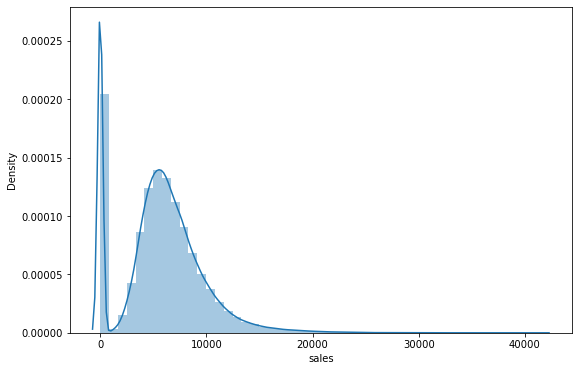

In [46]:
# plotar distribuição das vendas
plt.figure(figsize = (9,6))
sns.distplot(atributos_numericos['sales'])

Acima percebemos uma skew positiva (deslocada um pouco para a esquerda) e uma distribuição próxima de uma normal.

<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

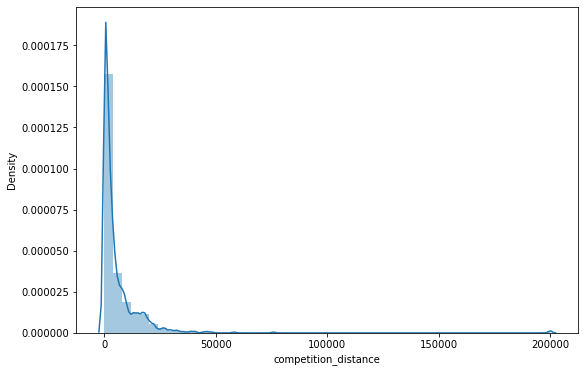

In [47]:
# plotar distribuição de competition_distance
plt.figure(figsize = (9,6))
sns.distplot(atributos_numericos['competition_distance'])

Parece ser uma distribuição poisson. Isso indica que os competidores estão próximos, com distância próxima de 0. Isso é indicado pela skew muito positiva. 

Como os valores estão muito concentrados, temos uma kurtose muito alta.

### Estatísticas das variáveis categóricas

In [48]:
# verificar quantos níveis cada coluna categórica possui
atributos_categoricos.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [49]:
# ver valores de state_holiday
atributos_categoricos['state_holiday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

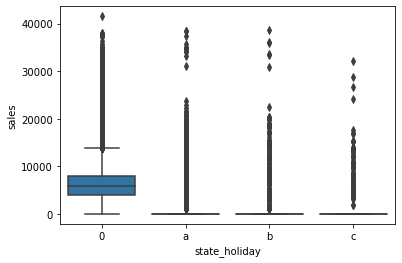

In [50]:
# boxplot vendas de acordo com o feriado estadual (df1)
sns.boxplot(data = df1,  x = 'state_holiday', y = 'sales');

O gráfico acima não nos mostra muita coisa, pois há dias com as lojas fechadas, dias com poucas vendas e dias com vendas altas. Isso gera um range muito alto. 

Podemos então filtrar esses números:

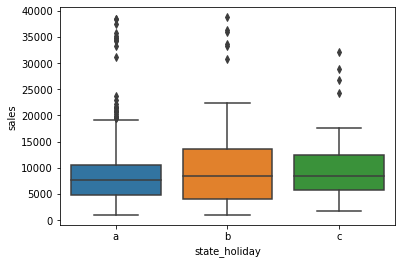

In [51]:
# State_holiday != 0(0 representa loja fechada?) e sales > 0
vendas_state_holiday = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
sns.boxplot(data = vendas_state_holiday,  x = 'state_holiday', y = 'sales');

<AxesSubplot:xlabel='assortment', ylabel='sales'>

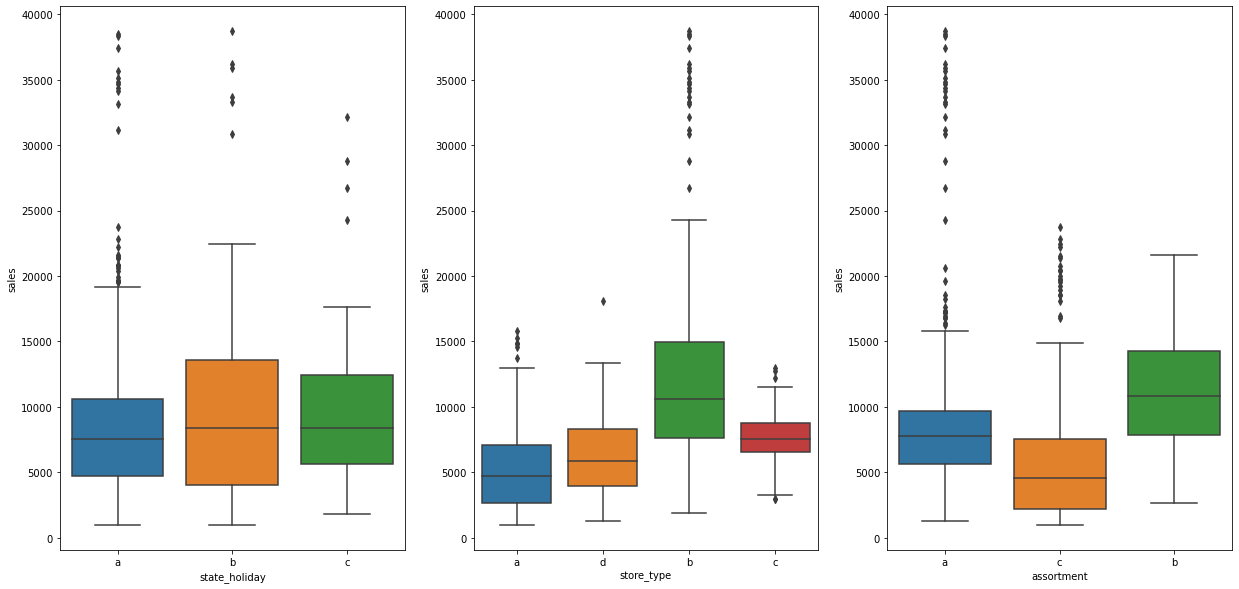

In [52]:
# fazer subplots com store's e assortment
plt.figure(figsize = (21,10))

plt.subplot(1,3,1)
sns.boxplot(data = vendas_state_holiday,  x = 'state_holiday', y = 'sales')

plt.subplot(1,3,2)
sns.boxplot(data = vendas_state_holiday,  x = 'store_type', y = 'sales')

plt.subplot(1,3,3)
sns.boxplot(data = vendas_state_holiday,  x = 'assortment', y = 'sales')

In [53]:
# explicar outliers (3x o desvio padrão)

# FEATURE ENGINEERING

## Mapa Mental de Hipóteses

Vamos construir um mapa mental para nos ajudar a extrair hipóteses para serem validades na análise exploratória de dados.

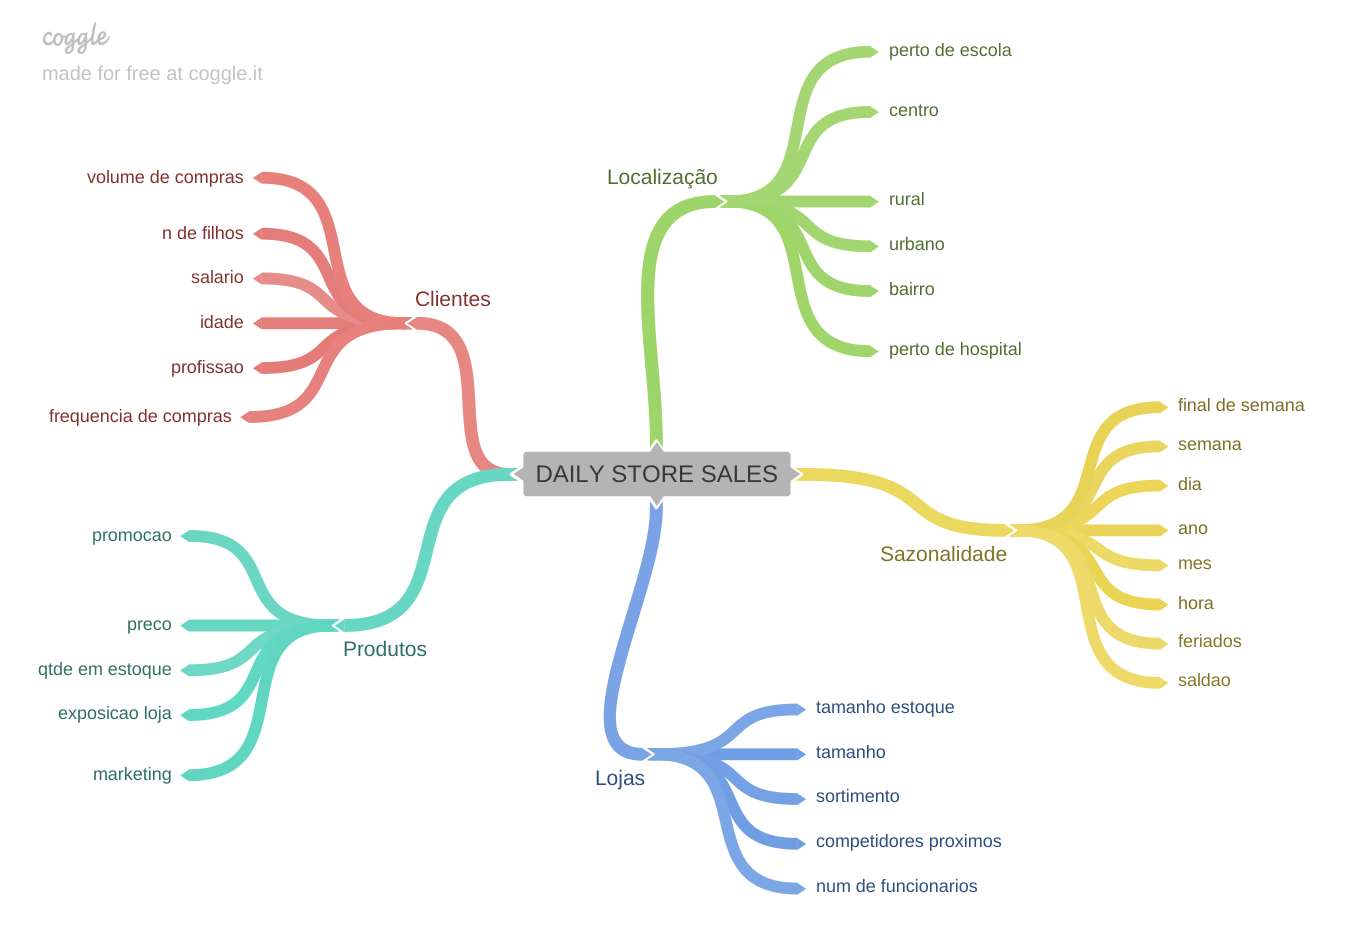

In [54]:
Image('img/MindMapHypothesis.png')

No mapa mental temos 3 elementos:

* o **Fenômeno** a ser estudado (Ex: as vendas a serem preditas);
* os **agentes** ou **entidades** que, possivelmente, podem impactar o fenômeno(Ex: as lojas); e
* os **atributos**, que descrevem cada uma das entidades (Ex: porte da loja, marketing dos produtos, etc.).

Para validar uma hipótese, podemos tentar relacionar um atributo de uma entidade com o fenômeno, podendo esse atributo (variável) influenciar no aumento ou na diminuição da resposta (variável target ou variável resposta). Deve ser lembrado o fato de que essa correlação não implica em uma relação de causa e efeito.

#### Criação das hipóteses

Serão usadas 3 entidades para formulação das hipóteses:

#### Hipóteses Loja

**1 ➜** Lojas com maior quadro de funcionários deveriam vender mais.

**2 ➜** Lojas com maior estoque deveriam vender mais.

**3 ➜** Lojas com maior porte deveriam vender mais.

**4 ➜** Lojas com maior sortimento deveriam vender mais.

**5 ➜** Lojas com competidores mais próximos deveriam vender menos.

#### Hipóteses Produto

**1 ➜** Lojas que investem mais em marketing deveriam vender mais.

**2 ➜** Lojas que expoem mais os produtos nas vitrines deveriam vender mais. 

**3 ➜** Lojas que possuem preços menores nos produtos deveriam vender mais.

**4 ➜** Lojas que tem preços menores nos produtos por mais tempo deveriam vender mais.

**5 ➜** Lojas com mais dias de promoção deveriam vender mais.

**6 ➜** Lojas com promoções ativas por mais tempo deveriam vender mais. 

**7 ➜** Lojas com mais promoções consecutivas deveriam vender mais.

#### Hipóteses Tempo (Sazonalidade)

**1 ➜** Lojas cabertas no feriado de Natal deveriam vender mais.

**2 ➜** Lojas deveriam vender mais ao longo dos anos. 

**3 ➜** Lojas deveriam vender mais no segundo semestre do ano. 

**4 ➜** Lojas deveriam vender mais a partir do dia 10 de cada mês. 

**5 ➜** Lojas deveriam vender menos nos finais de semana. 

**6 ➜** Lojas deveriam vender menos nos feriados escolares.

Depois da criação das hipóteses, devemos priorizar algumas delas para que sejam validadas.

#### Lista final de hipóteses

Aqui o critério pode ser o seguinte: temos os dados necessários para validar essa hipóteses disponíveis no dataset? Caso a resposta seja sim, essa hipótese entrará na lista final.

**1 ➜** Lojas com maior sortimento deveriam vender mais.

**2 ➜** Lojas com competidores mais próximos deveriam vender menos.

**3 ➜** Lojas com competidores há mais tempo deveriam vender mais.

**4 ➜** Lojas com mais dias de promoção deveriam vender mais.

**5 ➜** Lojas com promoções ativas por mais tempo deveriam vender mais. 

**6 ➜** Lojas com mais promoções consecutivas deveriam vender mais.

**7 ➜** Lojas cabertas no feriado de Natal deveriam vender mais.

**8 ➜** Lojas deveriam vender mais ao longo dos anos. 

**9 ➜** Lojas deveriam vender mais no segundo semestre do ano. 

**10 ➜** Lojas deveriam vender mais a partir do dia 10 de cada mês. 

**11 ➜** Lojas deveriam vender menos nos finais de semana. 

**12 ➜** Lojas deveriam vender menos nos feriados escolares.

## Feature Engineering

Vamos derivar as variáveis nessa seção.

In [55]:
# fazer cópia do dataset para df2
df2 = df1.copy()

In [56]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

In [57]:
# competition since -> vai dizer o tempo entre a data da compra (agora) e a data do inicio da competição
# terá ano, mês e dia
# precisamos extrair o mês e o ano do início da competição. O dia será 1
# usar datetime.datetime, lambda e apply 
# extrair o tempo, em dias, entre a data da venda e o início da promoção usando lambda e days.Converter int
# o parâmetro "axis" deve ser definido na função "apply", pois vamos utilizar mais de uma coluna
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], 
                                             month = x['competition_open_since_month'], day = 1), axis = 1)

# calculando o número de dias (dividir por 30)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype('int')

In [58]:
# promo since para promo_time_week -> tempo de promoção ativa, em semanas
# Esse caso é um pouco complicado, pois temos promo2_since_year e promo2_since_week. 
# concatenar as 2 variáveis

df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', 
                                                                                   '%Y-%W-%w') - datetime.timedelta(days = 7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7 ).apply(lambda x: x.days).astype('int')

In [59]:
# assortment
# colocar os assortments que as letras representam
# usar lambda
# substituir dentro da própria variável
# a = basic, b = extra, c = extended

df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

In [60]:
# state_holiday
# mesmo raciocínio de assortment
# caso não seja de algum dos feriados, retornar "regular_holiday"
# substituir dentro da própria variável
# a = public holiday, b = Easter holiday, c = Christmas, 0 = None

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x == 'a' else 'Easter holiday' if x == 'b' else 'Christmas' if x == 'c' else 'regular day')                               

# FILTRAGEM DE VARIÁVEIS

A filtragem de variáveis pode ser feita pensando nas restrições de negócio.

O conceito de Filtragem de variáveis é diferente de Seleção de variáveis. 

Filtragem de variáveis filtragem de variáveis pode ser feita pensando antecipadamente nas restrições de negócio. Por exemplo, se poderemos usar ou não uma variável específica no momento do deploy do modelo.

Seleção de variáveis visa encontrar as variáveis mais relevantes para o modelo, verificando as correlações das variáveis independentes com a variável target e entre as próprias variáveis independentes.

Vamos começar fazendo a filtragem das linhas e depois a seleção das colunas.

In [61]:
# cópia do dataset par df3
df3 = df2.copy()

## Filtragem das linhas

* A coluna **"open"** diz se a loja está aberta ou não. Contudo, nos dias em que a loja está fechada temos 0 vendas. Sendo assim, não temos aprendizado nenhum com essa coluna e não queremos as linhas onde seu valor é 0.

* A coluna **"sales"** nos mostra o número de vendas. As linhas com vendas == 0 não nos interessam.

In [62]:
# open != 0
# sales > 0
# salvar no próprio df3
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## Seleção das colunas

* A coluna **"customers"**, caso seja utilizada, será necessária no momento da predição das vendas. Contudo, não será possível, inicialmente, saber o número de clientes durante as próximas 6 semanas. Para isso, teríamos que fazer um projeto separado para predição de quantos clientes passariam pelas lojas nesse período e utilizar essa predição como input. Essa não é nossa intenção!

* Após a exclusão das linhas onde a coluna **"open"** possui o valor 0, restou apenas o valor 1 em cada uma de suas linhas. Sendo assim, não há necessidade de manter essa coluna.

* A coluna **"promo_interval"** foi criada apenas para derivar is_promo e a coluna **"month_map"** também foi criada apenas como auxiliar.

In [63]:
# dropar 'customers', 'open', 'promo_interval' e 'month_map'
# salvar dentro de df3
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3.drop(cols_drop, axis = 1, inplace = True)

# ANÁLISE EXPLORATÓRIA DE DADOS

Podemos verificar através dessa etapa como as variáveis impactam o fenômeno/variável target (vendas) e qual é a força desse impacto. Seus objetivos são:

1 ➜ Ganhar experiência de negócio

2 ➜ Validar hipóteses de negócio (insights)

3 ➜ Perceber variáveis que são importantes para o modelo.

A Análise Exploratória de dados possui 3 tipos:

1 ➜ **Análise Univariada**, onde procuramos conhecer o comportamento de uma variável

2 ➜ **Análise Bivariada**, onde tentamos responder a pergunta: como uma variável impacta na target/resposta? (correlação, validação de hipóteses, etc.)

3 ➜ **Análise Multivariada**, aqui olhamos mais de uma variável e seu impacto na variável target/resposta e também entre elas mesmas.

In [64]:
# cópia do dataset para df4
df4 = df3.copy()

## Análise Univariada

### Análise da variável target/resposta

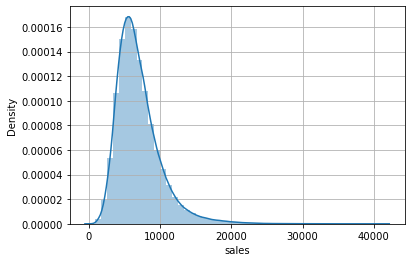

In [65]:
# plotar distribuição de sales
sns.distplot(df4['sales'])
plt.grid();

Distribuição próxima de uma normal;
Possui skew positiva;
Possui Curtose.

Há modelos de Machine Learning que necessitam de dados normalizados para suas predições. Apenas para exemplo, poderíamos usar os dados das vendas fazendo a multiplicação pelo log, utilizando uma função do numpy, para aproximar mais esses dados de uma curva normal.

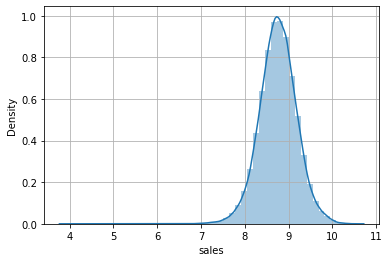

In [66]:
sns.distplot(np.log1p(df4['sales']))
plt.grid();

### Análise de variáveis numéricas

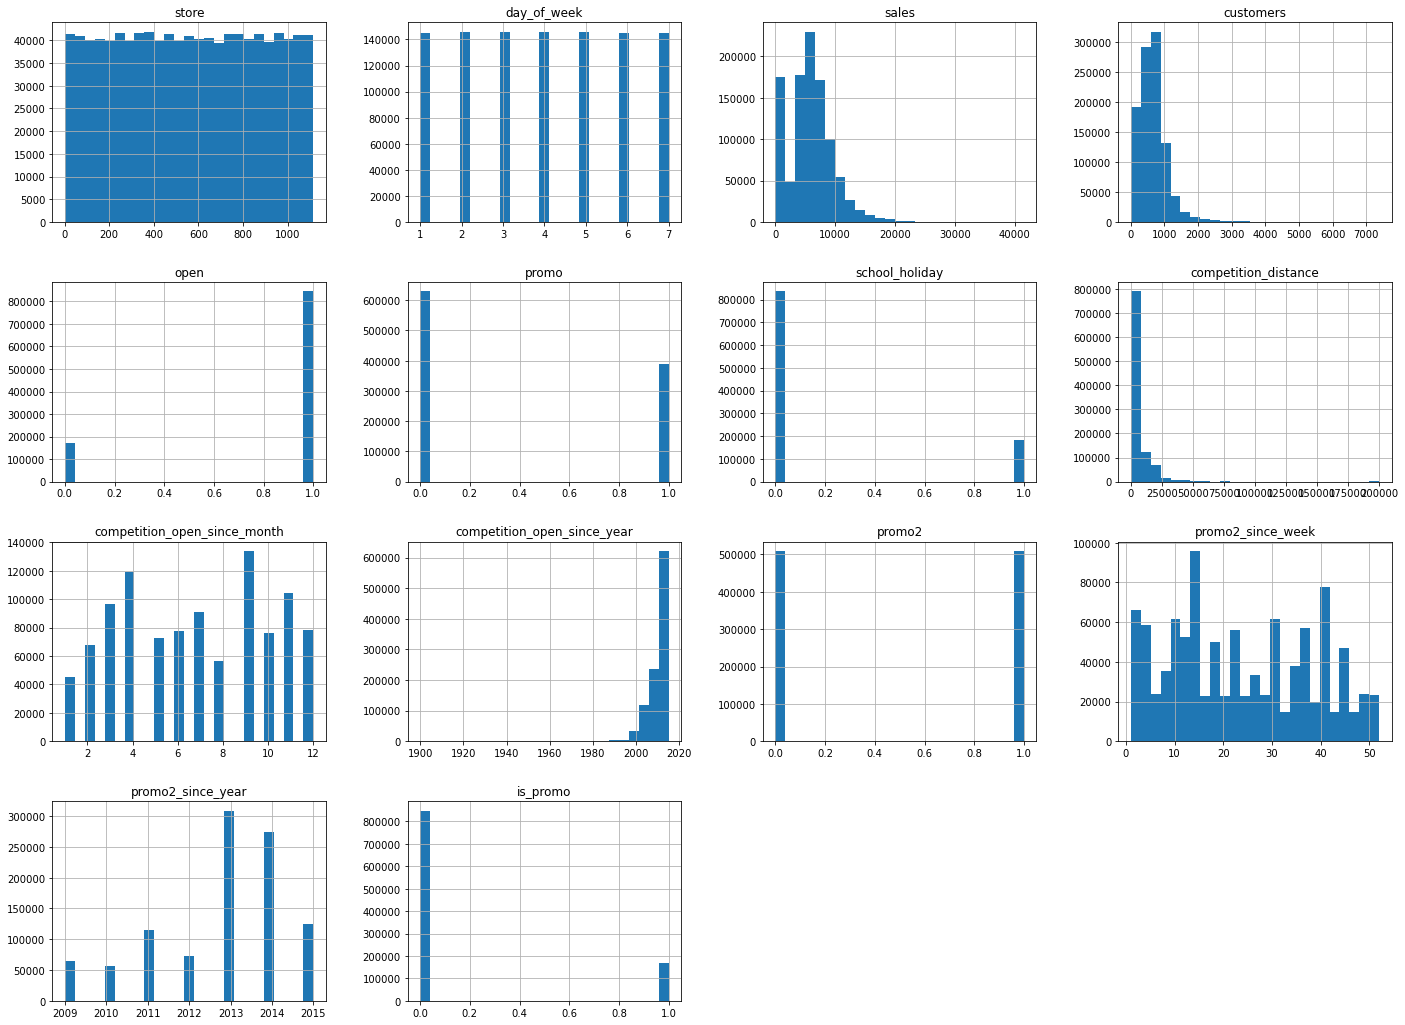

In [67]:
# histograma das variáveis numéricas (25 bins)
#plt.figure(figsize = (25,25))
atributos_numericos.hist(bins = 25, figsize = (24,18));

# ********************** aumentar titulo**********************************************

Um exemplo de observação interessante nos gráficos acima é em relação a coluna "day_of_week", pois, independentemente do dia da semana, as vendas parecem ser iguais. Essa variável provavelmente não trará nada relevante para o modelo.

### Análise de variáveis categóricas

In [68]:
# head
atributos_categoricos.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [69]:
# drop_duplicate ou unique das categóricas
print('Níveis de "state_holiday": ', atributos_categoricos['state_holiday'].unique())
print('Níveis de "store_type": ', atributos_categoricos['store_type'].unique())
print('Níveis de "assortment": ', atributos_categoricos['assortment'].unique())

Níveis de "state_holiday":  ['0' 'a' 'b' 'c']
Níveis de "store_type":  ['c' 'a' 'd' 'b']
Níveis de "assortment":  ['a' 'c' 'b']


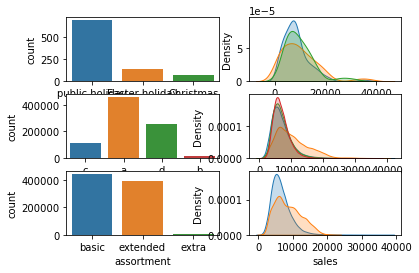

In [70]:
# filtrar != de dia normal e plotar um countplot de state_holiday(subplot)
a = df4[df4['state_holiday'] != 'regular day']
plt.subplot(3,2,1)
sns.countplot(a['state_holiday'])
# kdeplot das vendas em state_holiday, para cada tipo de feriado (subplot)
# o parâmetro shade deixa mais transparente os gráficos sobrepostos
# fazer o mesmo para as outras 3
plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public holiday']['sales'], label = 'public holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'Easter holiday']['sales'], label = 'Easter holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'Christmas']['sales'], label = 'Christmas', shade = True)
# mesmo raciocínio acima, agora para store_type e assortment
# 3 linhas, 2 colunas
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True)

plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extanded']['sales'], label = 'a', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'b', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'c', shade = True);

## Análise Bivariada

Nessa etapa vamos tentar validar algumas hipóteses da lista final e tentar verificar quais variáveis tem relevância para o modelo.

### H1 ➜ Lojas com maior sortimento deveriam vender mais.

Nessa validação de hipótese, vamos usar 2 variáveis: assortment, referente ao sortimento de produtos da loja, e sales, referente às vendas.

Quais são as vendas para cada tipo de assortment?

In [71]:
# agrupar as vendas e assortments por assortments. Somar. Resetar o indice para tornar um df
# salvar em uma variável
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
aux1

,assortment,sales
0,basic,2945750070
1,extended,2856484241
2,extra,70946312


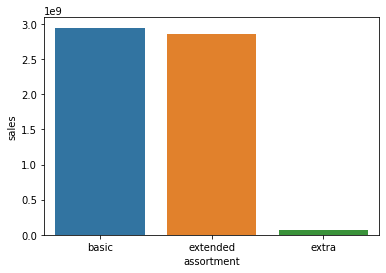

In [72]:
# apresentar em gráfico de barras
ax = sns.barplot(x = 'assortment', y = 'sales', data = aux1);

Podemos perceber que lojas com assortment maior, referenciado pela label "extra", vendem menos, não validando nossa primeira hipótese.

Lembrando que assumimos o tamanho do sortimento dessa forma por não termos mais informações sobre esses dados.

Será que as vendas do tipo "extra" de sortimento tiveram alteração no seu comportamento com o passar do tempo? Será que já vendeu mais no passado?

Para essa verificação, precisamos das vendas por assortment, por semana do ano, durante o período registrado.

In [73]:
# agrupar as vendas, assortments e semana do ano por assortments e semana do ano. Somar. 
# Resetar o indice para tornar um df
# salvar em uma variável
aux1 = df4[['assortment', 'year_week', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()

In [74]:
# head
aux1.head()

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693


Para visualizarmos melhor por cada tipo de sortimento, podemos fazer um pivô do dataframe.

In [75]:
# pivotar (indice = semana, columns = sortimentos, valores = vendas)
# salvar em uma variável
# plotar linha
aux2 = aux1.pivot(index='year_week', columns='assortment', values='sales')
aux2.head()

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061


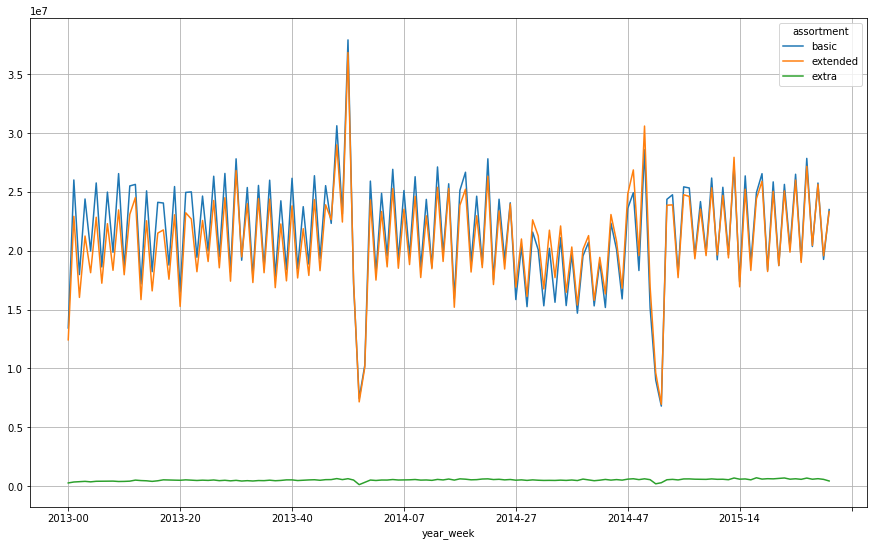

In [76]:
aux2.plot(figsize = (15,9))
plt.grid();

Como o número de vendas dos sortimentos "extended" e "basic" é muito maior, acaba puxando a escala para cima. Assim, não conseguimos analisar o comportamento do sortimento "extra". Podemos visualizá-lo separadamente.

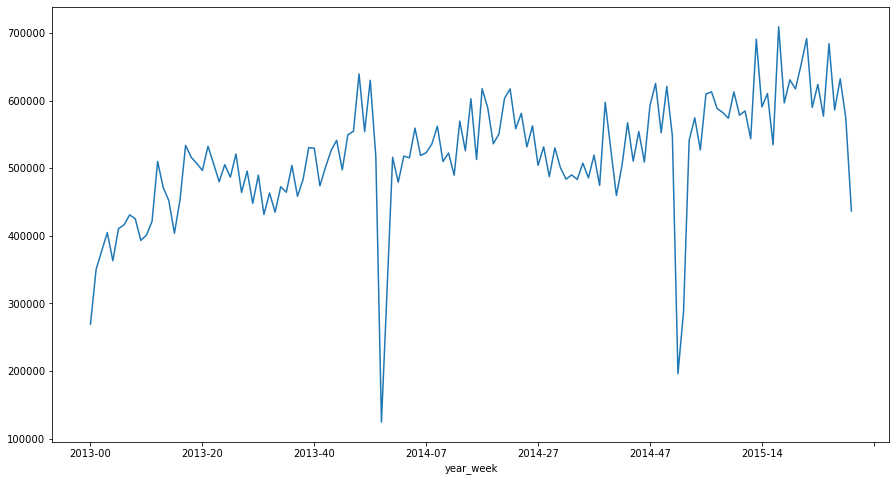

In [77]:
# filtrar assortment "extra"
# pivotar
# plotar linha
aux2['extra'].plot(figsize = (15,8));

<u><b>CONCLUSÃO:</b></u>

Diante da análise, podemos afirmar que lojas com sortimento maior (assumimos como "extra") <b>não</b> vendem mais.

A variável assorment mostra-se como relevante para o modelo, pois, apesar de "extended" e "basic" possuírem comportamentos praticamente iguais, "extra" mostra salzonalidade diferente desses outros dois tipos. O modelo pode realmente aprender algo com essa variável.

### H2 ➜ Lojas com competidores mais próximos deveriam vender menos.

Vamos utilizar as variáveis "competition_distance"  e "sales" para tentar validar essa hipótese.

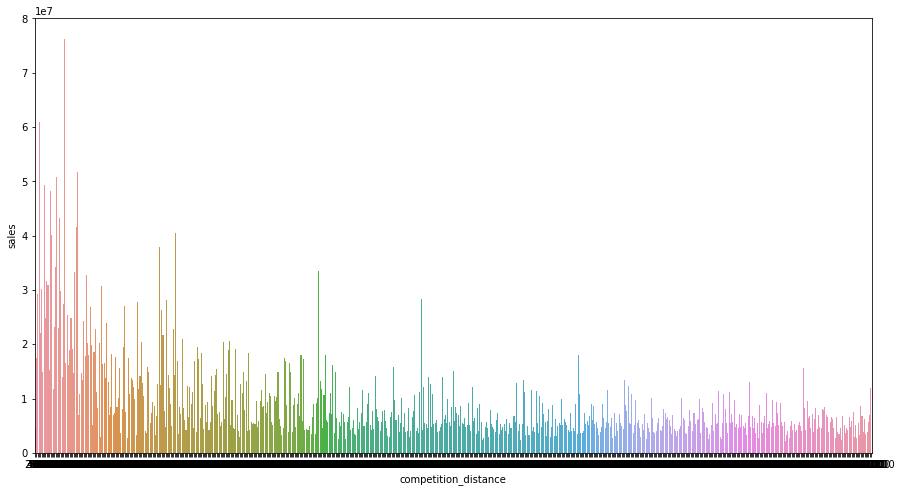

In [78]:
# agrupar "competition_distance" e "sales" por competition_distance
# somar
# resetar indice
# salvar em uma variavel
# plotar barras
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize = (15,8))
sns.barplot(x = 'competition_distance', y = 'sales', data = aux1);

O gráfico acima não nos mostra nada relevante, por há nele muito granularidade. Acabou ficando muito dividido, difícil de entender. 

Uma solução seria separar as distâncias por intervalos ou tentar visualizar em um scatterplot.

In [79]:
comp_max = aux1['competition_distance'].max()

In [80]:
# criar variável bins com uma lista que vá de 0 até o valor maximo, de 1000 em 1000
# usar cut para criar nova coluna "competition_distance_binned" com o intervalo
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)

In [81]:
aux1

,competition_distance,sales,competition_distance_binned
0,20.0,4579807,"(0.0, 1000.0]"
1,30.0,17552666,"(0.0, 1000.0]"
2,40.0,29261626,"(0.0, 1000.0]"
3,50.0,60835848,"(0.0, 1000.0]"
4,60.0,22088359,"(0.0, 1000.0]"
...,...,...,...
650,46590.0,3554993,NaN
651,48330.0,3798660,NaN
652,58260.0,5718883,NaN
653,75860.0,6896821,NaN


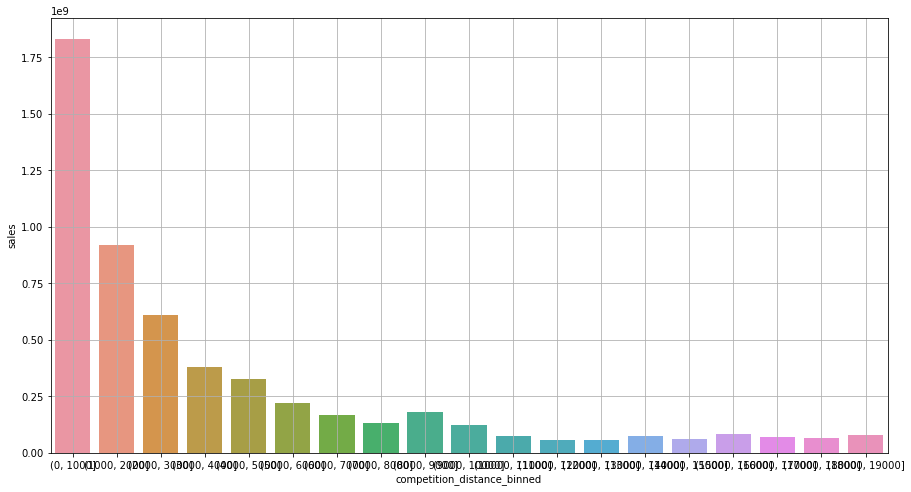

In [82]:
# agrupar e somar novamente, agora com competition_distance_binned, para aux2
# plotar barras
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

plt.figure(figsize = (15,8))
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2)
plt.grid();

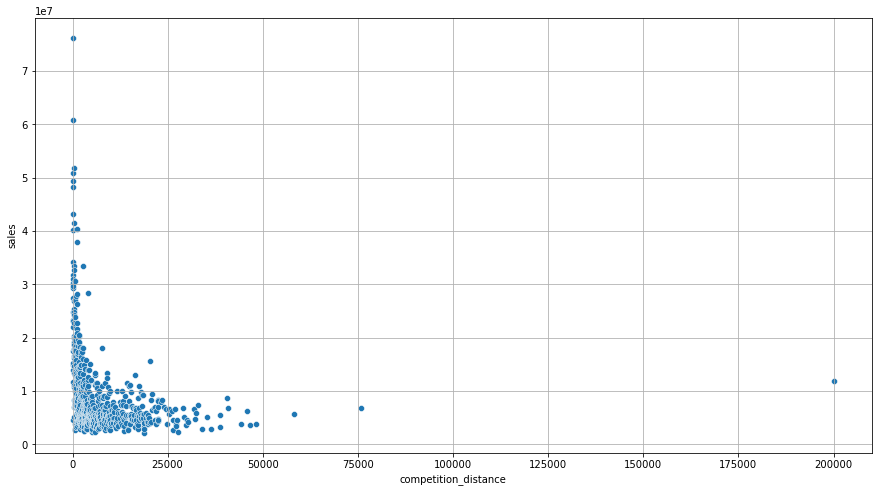

In [83]:
# plotar scatter
plt.figure(figsize = (15,8))
sns.scatterplot(data = aux1, x = 'competition_distance', y = 'sales')
plt.grid();

<u><b>CONCLUSÃO:</b></u>

O senso comum indicaria que, sim, lojas com competidores mais próximos deveriam vender menos, de acordo com o aumento da concorrência. Contudo, não é isso que o gráfico acima nos mostra.

Temos aqui, então, um insight interessante, pois <b>lojas com competidores mais próximos acabam vendendo mais</b>, observando também que, quanto menor a distância do competidor mais próximo, maior é o valor das vendas.

Podemos ainda verificar se a variável "competition_distance" será importante para o modelo.

Podemos plotar um gráfico para mostrar a força da correlação entre "competition_distance" e as vendas.

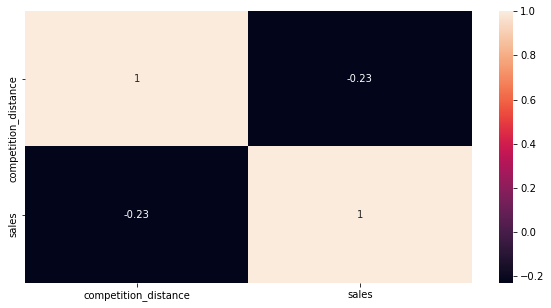

In [84]:
# heatmap de aux1 
# mostrar também o valor
# bottom, top = x.getylim()
# x.set_ylim( bottom + 0.5, top - 0.5)
plt.figure(figsize = (10, 5))
sns.heatmap(aux1.corr(), annot = True);

Temos uma correlação de -0.23 entre "competition_distance" e "sales". Mesmo não sendo tão alta, é relevante para ser apresentada ao modelo.

### H3 ➜ Lojas com competidores há mais tempo deveriam vender mais.

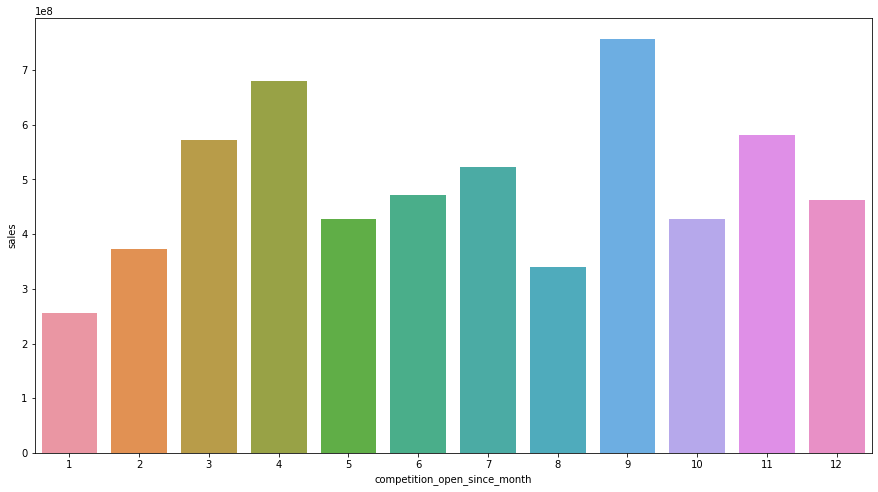

In [85]:
# agrupar "competition_open_since_month" e "sales" por competition_distance
# somar
# resetar indice
# salvar em uma variavel
# plotar barras
aux1 = df4[['competition_open_since_month', 'sales']].groupby('competition_open_since_month').sum().reset_index()

plt.figure(figsize = (15,8))
sns.barplot(x = 'competition_open_since_month', y = 'sales', data = aux1);

Esse gráfico não nos mostra nada de relevante. Estamos interessados em saber qual é a relação entre o tempo em que o competidor está aberto com as vendas.

Precisamos, então, utilizar a variável que derivamos chamada competition_time_month, que diz há quanto tempo o competidor está aberto (comparado com a data da venda). Vamos filtrar apenas com esse tempo menor do que 120 e diferente de 0.

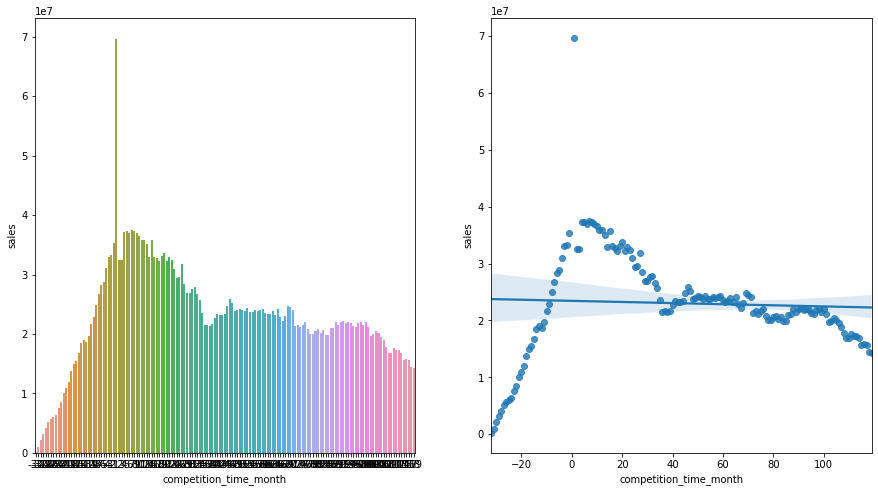

In [86]:
# agrupar "competition_time_month" e "sales" por competition_time_month
# somar
# resetar indice
# filtrar para aux2
# salvar em uma variavel
# plotar barras
# regplot para mostrar a tendência
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

plt.figure(figsize = (15,8))

plt.subplot(1,2,1)
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2)

plt.subplot(1,2,2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);

O gráfico de barras mostra valores negativos onde a venda foi realizada antes da abertura de um competidor. O regplot nos mostra a tendência separadamente.

Podemos observar que quanto mais próximo de 0, maior o número de vendas. Isso significa que quanto mais recente for a competição, maior é a venda.

<u><b>CONCLUSÃO:</b></u>

Podemos dizer, após a análise, que <b>lojas com competidores há mais tempo vendem menos</b>.

Podemos agora verificar que, de acordo com a força da correlação entre "competition_time_month" e as vendas, a primeira será relevante para o modelo.

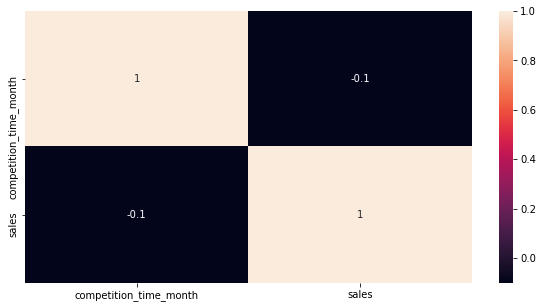

In [87]:
# fazer o heatmap
plt.figure(figsize = (10, 5))
sns.heatmap(aux1.corr(), annot = True);

### H4 ➜ Lojas com promoções ativas por mais tempo deveriam vender mais.

Vamos usar a variável "promo_time_week", que foi derivada, e "sales".

A variável "promo_time_week" representa o tempo desde que se iniciou a promoção extendida. O cálculo foi feito subtraindo a data da venda da data do início dessa promoção. Seus resultados podem ser negativos ou positivos. São negativos quando a data da venda é anterior a data do início da promoção extendida, enquanto são positivos quando a data da venda é posterior a data de início dessa promoção.

Tendo isso em vista, se o valor for negativo, estamos no período tradicional de promoções. Se for positivo ou igual a 0, estaremos no período de promoção extendida.

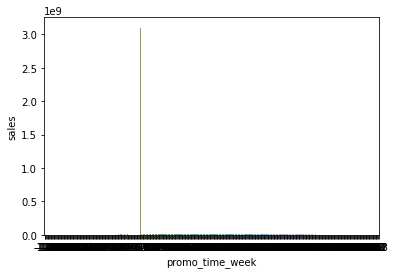

In [88]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

sns.barplot(x = 'promo_time_week', y = 'sales', data = aux1);

O gráfico, como era esperado, não nos mostra o comportamento dos dados. Podemos então verificar os dois períodos diferentes, da promoção tradicional e da promoção extendida.

In [89]:
# filtrar promo_time_week maior do que 0 (período extendido)
# salvar em uma variável
promo_extended = aux1[aux1['promo_time_week'] > 0]

In [90]:
# filtrar promo_time_week menor do que 0 (período tradicional)
# salvar em uma variável
promo = aux1[aux1['promo_time_week'] < 0]

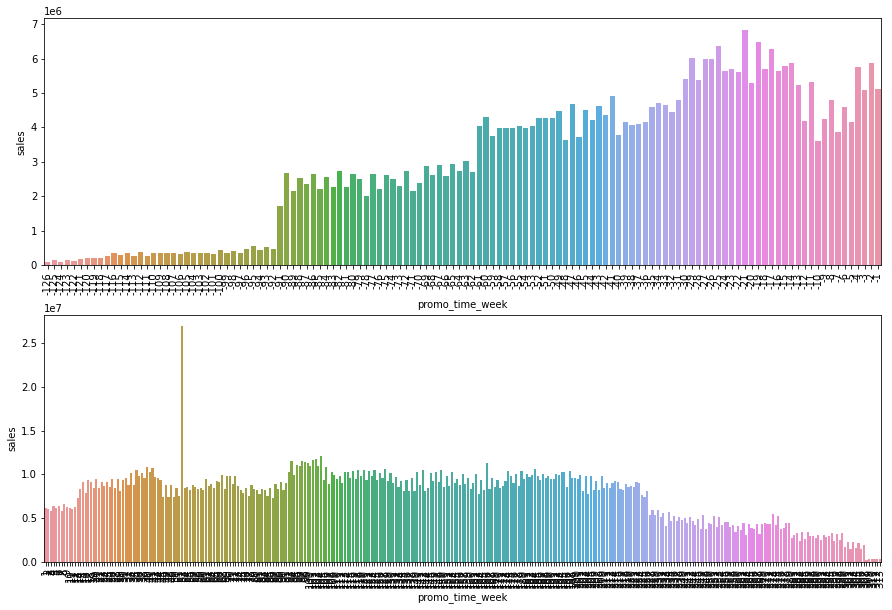

In [91]:
# 2 subplots
plt.figure(figsize = (15,10))

plt.subplot(2,1,1)
#sns.set_style('darkgrid')
ax = sns.barplot(x = 'promo_time_week', y = 'sales', data = promo)
plt.xticks(rotation = 90)

plt.subplot(2,1,2)
#sns.set_style('darkgrid')
ax = sns.barplot(x = 'promo_time_week', y = 'sales', data = promo_extended)
plt.xticks(rotation = 90);

<b><u>CONCLUSÃO: </u></b>

O gráfico da promoção extendida nos mostra que é provável que ela tenha um período de funcionamento mais efetivo, já que as vendas começam a cair em certo período.

Já o gráfico da promoção tradicional começa a aumentar conforme se aproxima o início da promoção extendida. Isso pode, por exemplo, estar relacionado com o marketing relacionado à  esse início. Contudo, isso só poderia ser comprovado com dados referentes à área de marketing, nesse período.

Essas análises nos levam ao entendimento de que <b>lojas com promoções ativas por mais tempo não necessariamente vendem mais</b>, já que após certo período dentro da promoção as vendas começam a cair..

Observando os gráficos, notamos um comportamento das vendas em relação ao período em que a promoção está ativa. Isso mostra que a variável "promo_time_week" pode ter alguma relevância para o modelo. 

Podemos então plotar um gráfico para mostrar a tendência nos dados e um heatmap para medir a força da correlação entre essas duas variáveis:

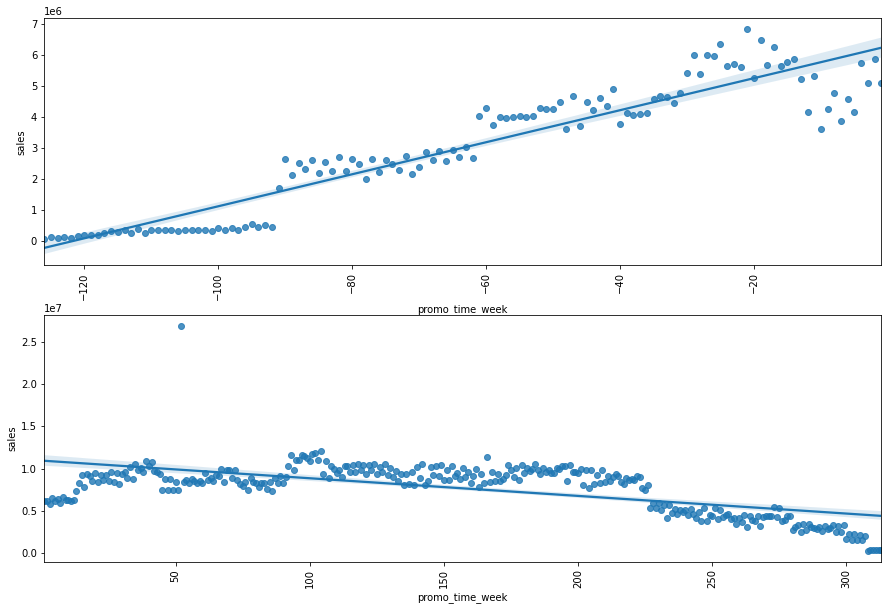

In [92]:
# regplot dos dois períodos
plt.figure(figsize = (15,10))

plt.subplot(2,1,1)
#sns.set_style('darkgrid')
ax = sns.regplot(x = 'promo_time_week', y = 'sales', data = promo)
plt.xticks(rotation = 90)

plt.subplot(2,1,2)
#sns.set_style('darkgrid')
ax = sns.regplot(x = 'promo_time_week', y = 'sales', data = promo_extended)
plt.xticks(rotation = 90);

Para o heatmap passamos a variável aux1, sem divisão dos períodos, pois o modelo enxerga a variável como um todo. A quebra em dois períodos foi feita apenas para entendermos o comportamento das vendas.

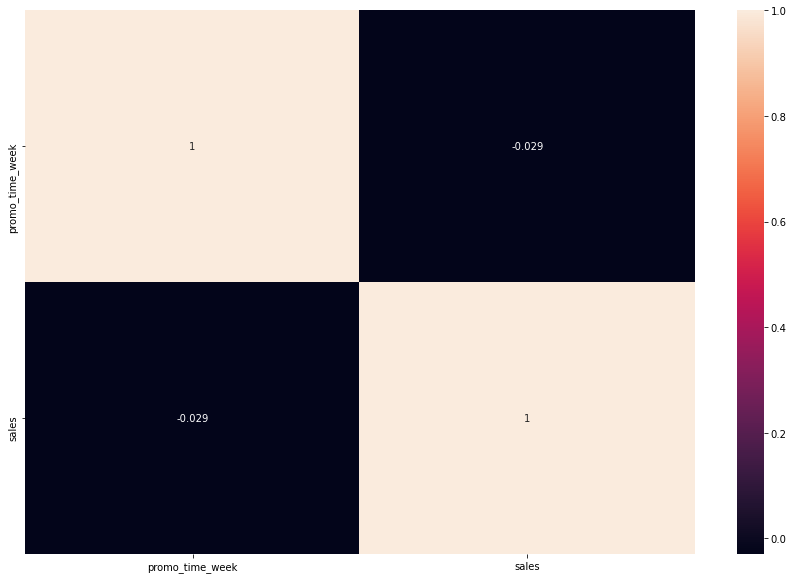

In [93]:
# heatmap
plt.figure(figsize = (15,10))
sns.heatmap(aux1.corr(), annot = True);

O heatmap acima nos mostra que a correlação entre a variável independente "promo_time_week" e a variável target "sales" é muito fraca. Isso pode acontencer pelo período constante antes do início do decaimento das vendas em relação à promoção extendida. Esse período constante é bem maior e estável do que o do decaimento citado.

Provavelmente essa variável independente não terá muita relevância para o modelo.

### <s>H5 ➜ Lojas com mais dias de promoção deveriam vender mais</s>

SERÁ VALIDADA NO PRÓXIMO CICLO (CRISP-DM)

A hipótese anterior, H4, quer dizer "mais dias de promoção". 

### H6 ➜ Lojas com promoções consecutivas deveriam vender mais

Podemos entender como promoção consecutiva o fato de a loja entrar na promoção extendida.

Para isso vamos usar a variável "promo", que diz se a loja está com seus produtos na promoção "tradicional", "promo2", que está relacionada com a promoção extendida, e "sales", para as vendas.

In [94]:
# agrupar as 3 variáveis por promo e por promo2
# somar
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


O dataframe acima nos mostra a influência da promoção tradicional nas vendas. O menor valor em vendas aparece quando apenas a promoção extendida está ativa.

Será que esse comportamento mudou ao longo do tempo?

Será que lojas que tiveram promoção apenas tradicional tiveram mudança de comportamento nas vendas quando iniciaram a promoção extendida?

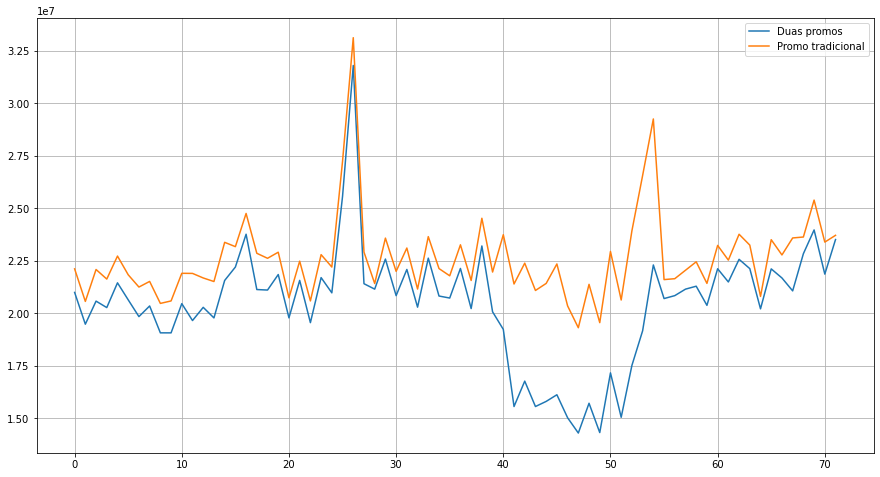

In [95]:
# filtrar todas as lojas que estiveram nas 2 promoções ao mesmo tempo
# utilizar apenas as colunas year_week e sales
# agrupar por year_week, somar e resetar o indice
# inserir plot em um axis
aux1 = df4[['year_week', 'sales']][(df4['promo'] == 1) & (df4['promo2'] == 1)].groupby('year_week').sum().reset_index()
ax = aux1.plot(figsize = (15,8))
aux2 = df4[['year_week', 'sales']][(df4['promo'] == 1) & (df4['promo2'] == 0)].groupby('year_week').sum().reset_index()
aux2.plot( ax = ax)
ax.legend(['Duas promos', 'Promo tradicional'])
plt.grid()

<b><u>CONCLUSÃO:</u></b>

Podemos verificar que o comportamento das vendas nas lojas que extenderam a promoção é muito parecido com das vendas das lojas que ficaram apenas na promoção tradicional. Contudo, há nas vendas das lojas que passaram pelas 2 promoções um decaimento maior, além de terem volume menor.

Então podemos concluir que <b>lojas com promoções consecutivas não necessariamente vendem mais</b>.

Em relação à relevância para o modelo, as variáveis "promo" e "promo2" mostram um comportamento pontual, salvo por alguns picos e o decaimento citado. Ao que tudo indica, não serão relevantes para o modelo.

### H7 ➜ Lojas abertas durante o feriado de Natal deveriam vender mais

Usaremos as variáveis "state_holiday" e "sales". Devemos filtrar os feriados, deixando os dias normais de fora.

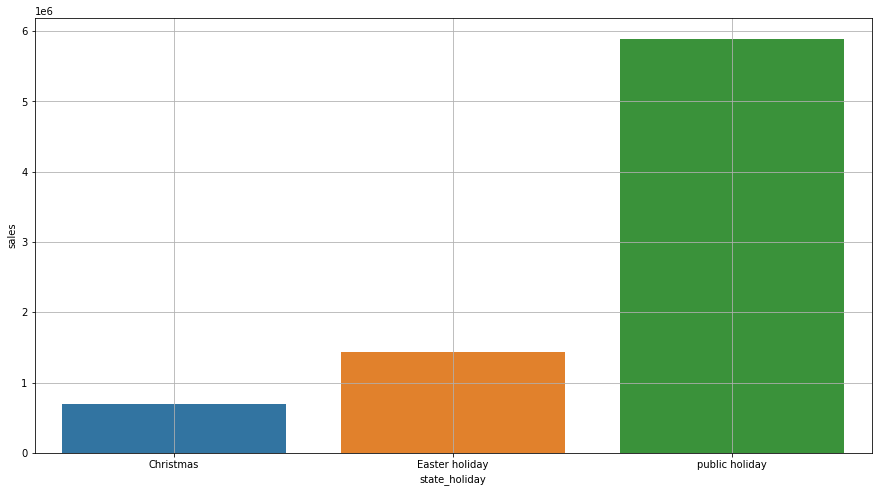

In [96]:
# filtrar sem 'regular day'
# agrupar "state_holiday" e "sales" por "state_holiday"
# somar
# resetar indice
# salvar em uma variável
# plotar barras
aux = df4[df4['state_holiday'] != 'regular day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()   

plt.figure(figsize = (15,8))
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1)
plt.grid();

Agora podemos verificar, ao longo dos anos, se o feriado de Natal chegou a vender mais que nos outros feriados.

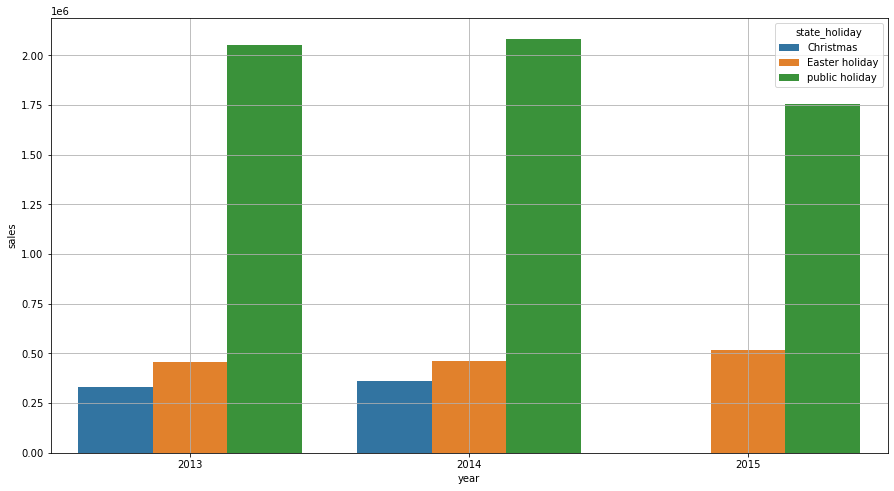

In [97]:
# agrupar "state_holiday" , 'year' e "sales" por "year"
# somar
# resetar indice
# salvar em uma variável
# plotar barras (com agrupamento pelos feriados)
aux2 = aux[[ 'state_holiday', 'year', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()   

plt.figure(figsize = (15,8))
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = aux2)
plt.grid();

O gráfico acima, apesar de incompleto (os dados são anteriores ao Natal de 2015) nos mostram uma tendência de alta nas vendas ano a ano, ainda que essa alta seja leve.

<b><u> CONCLUSÃO: </u></b>

Observamos que lojas abertas durante o feriado de Natal <b>não necessariamente vendem mais</b>. Essa hipótese <b>não foi validada</b>.

### H8 ➜ Lojas deveriam vender mais ao longo dos anos

Usaremos as variáveis "year" e "sales".

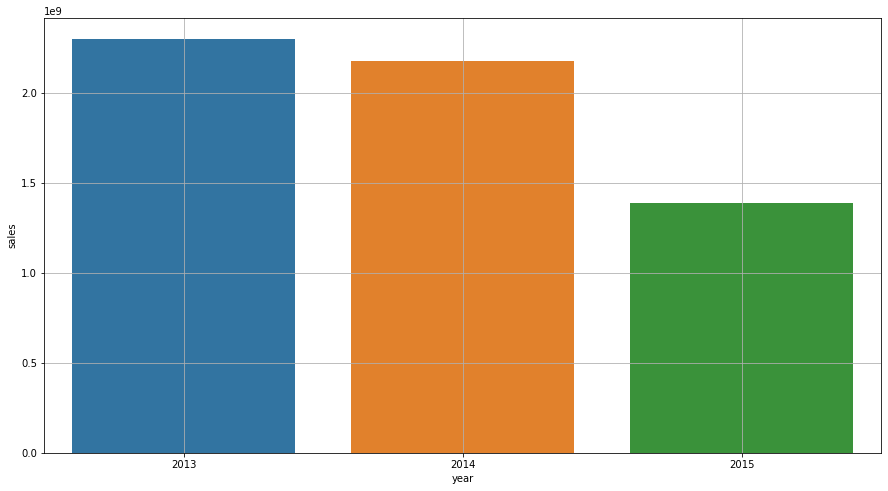

In [98]:
# agrupar "year" e "sales" por "year"
# somar
# resetar indice
# salvar em uma variável
# plotar barras
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.figure(figsize = (15,8))
sns.barplot(x = 'year', y = 'sales', data = aux1)
plt.grid();

Vamos agora verificar a tendência e a força da correlação da variável independente "year" com a variável target "sales".

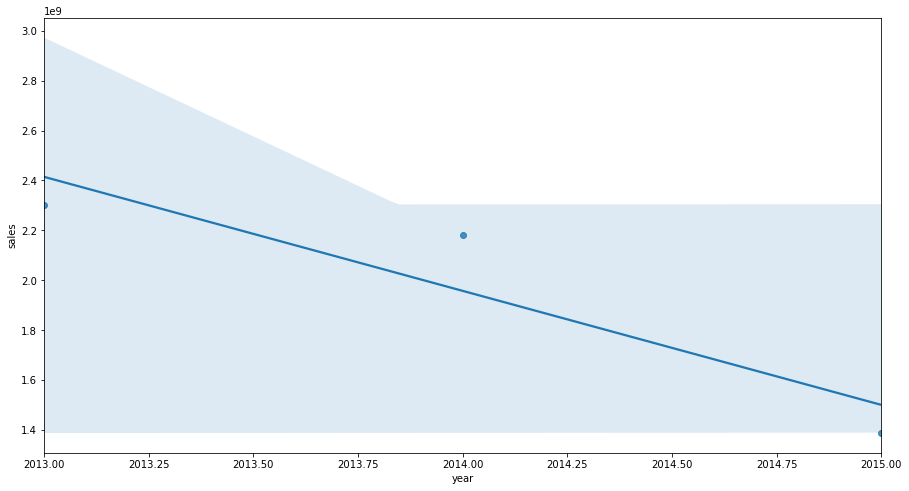

In [99]:
# regplot
plt.figure(figsize = (15,8))
sns.regplot(x = 'year', y = 'sales', data = aux1);

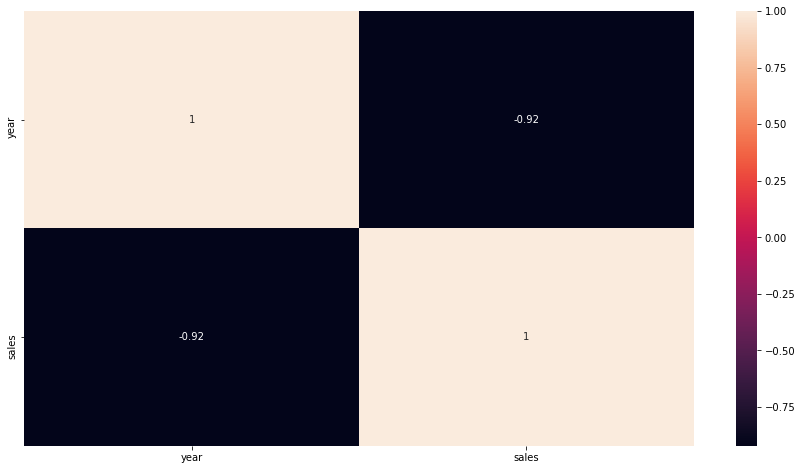

In [100]:
# heatmap
plt.figure(figsize = (15,8))
sns.heatmap(aux1.corr(), annot = True);

<b><u> CONCLUSÃO: </u></b>

Observamos nas análises que lojas <b>não venderam mais ao longo dos anos</b>. Portanto, a hipótese <b>não foi validada</b>.

Temos uma alta correlação negativa entre as variáveis year e sales. Conforme os anos aumentam, as vendas diminuem. Com isso, provavelmente a variável year será relevante para o modelo. Contudo, devemos lembrar que não temos os dados completos das vendas no ano de 2015 (só temos registros até julho de 2015).

### H9 ➜ Lojas deveriam vender mais no segundo semestre do ano

Usaremos as variáveis "month" e "sales".

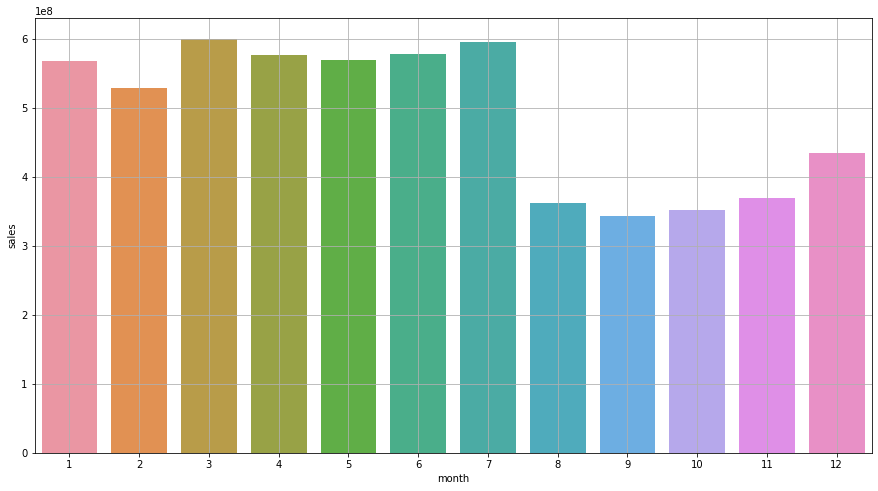

In [101]:
# mesmos procedimentos feitos na hipótese anterior
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.figure(figsize = (15,8))
sns.barplot(x = 'month', y = 'sales', data = aux1)
plt.grid();

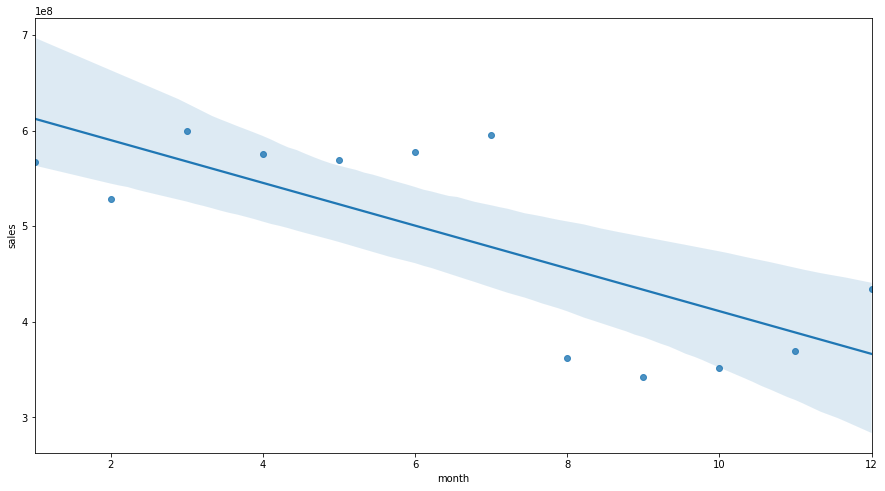

In [102]:
# regplot
plt.figure(figsize = (15,8))
sns.regplot(x = 'month', y = 'sales', data = aux1);

<b><u> CONCLUSÃO: </u></b>

Mais uma hipótese que não foi validade. Podemos verificar nos gráficos que as vendas caem a partir do mês de agosto.

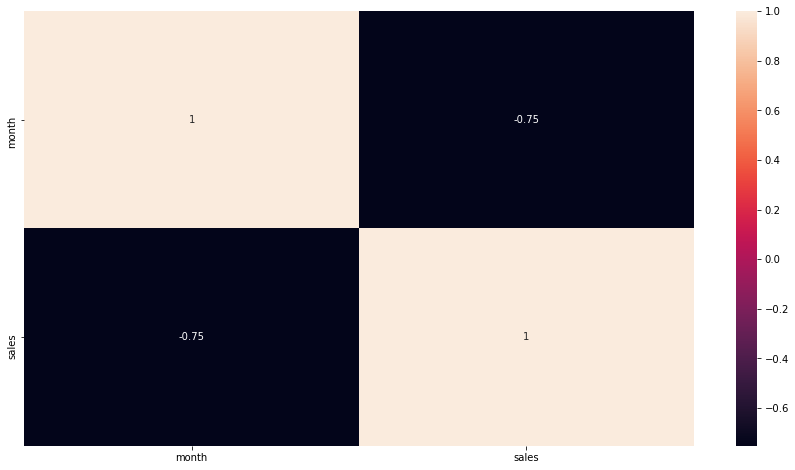

In [103]:
# heatmap
plt.figure(figsize = (15,8))
sns.heatmap(aux1.corr(), annot = True);

Temos aqui, também, uma alta correlação entre a variável independente "month" e a variável target, "sales". Essa é mais uma variável que, provavelmente, terá relevância para o modelo.

### H10 ➜ Lojas deveriam vender mais depois do dia 10 de cada mês

Usaremos as variáveis "day" e "sales".

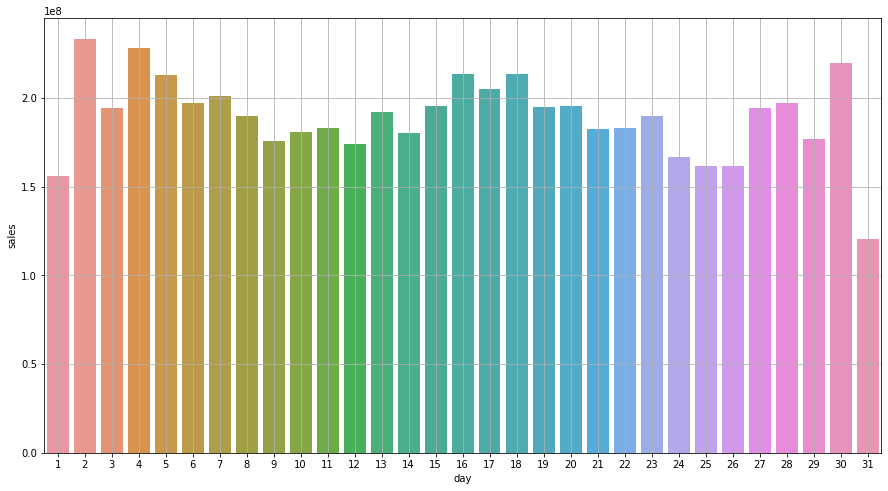

In [104]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.figure(figsize = (15,8))
sns.barplot(x = 'day', y = 'sales', data = aux1)
plt.grid();

Podemos criar uma coluna com "antes e depois", dizendo se o dia é antes ou depois do dia 10. Depois, plotar as vendas agrupadas de acordo com isso.

In [105]:
# criar a coluna
aux1['before_after'] = aux1['day'].apply(lambda x: 'after' if x >= 10 else 'before')

In [106]:
# soma das vendas agrupada por antes e depois
soma = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

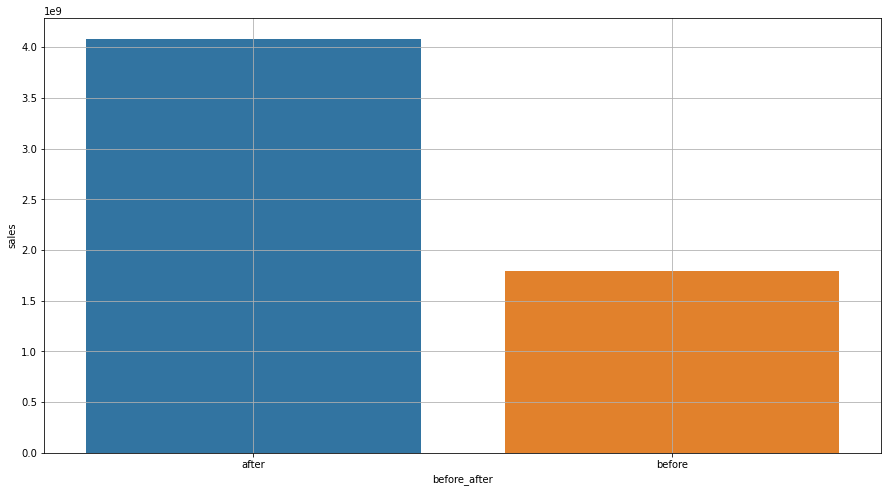

In [107]:
# plots
plt.figure(figsize = (15,8))
sns.barplot(x = 'before_after', y = 'sales', data = soma)
plt.grid();

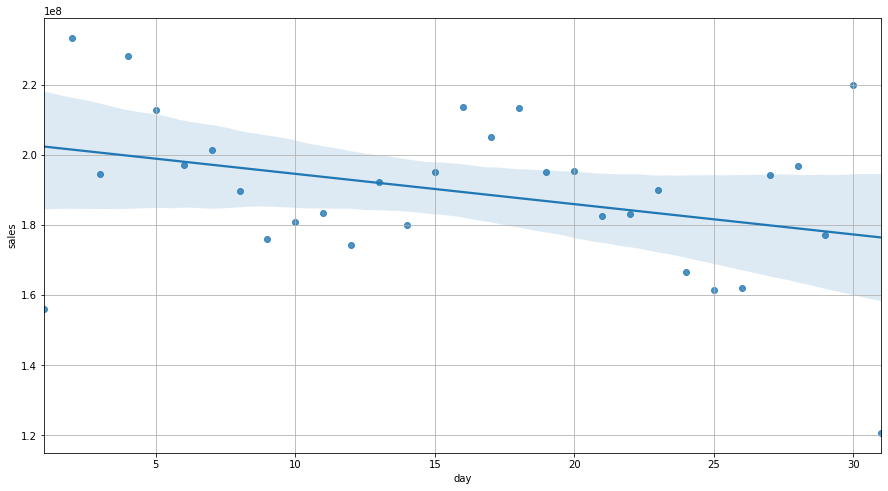

In [108]:
# regplot
plt.figure(figsize = (15,8))
sns.regplot(x = 'day', y = 'sales', data = aux1)
plt.grid();

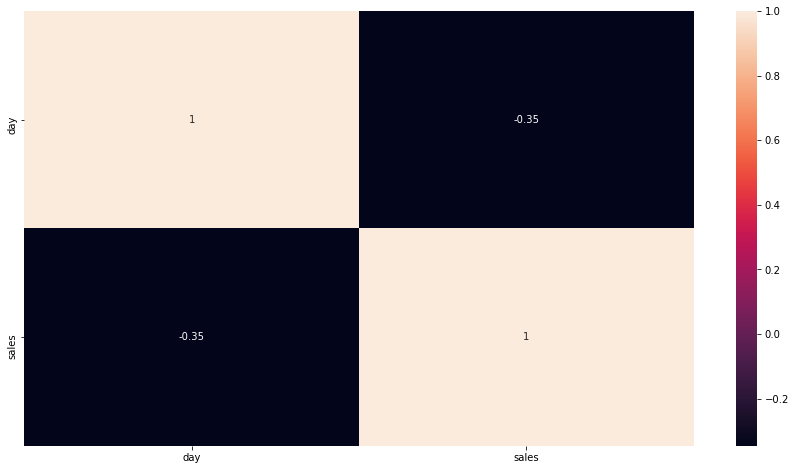

In [109]:
# heatmap
plt.figure(figsize = (15,8))
sns.heatmap(aux1.corr(), annot = True);

<b><u> CONCLUSÃO: </u></b>

<b>Lojas vendem mais depois do dia 10 de cada mês</b>. Assim, <b>validamos</b> essa hipótese.

### H11 ➜ Lojas deveriam vender menos nos finais de semana

Vamos utilizar as variáveis "day_of_week" e "sales".

In [110]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

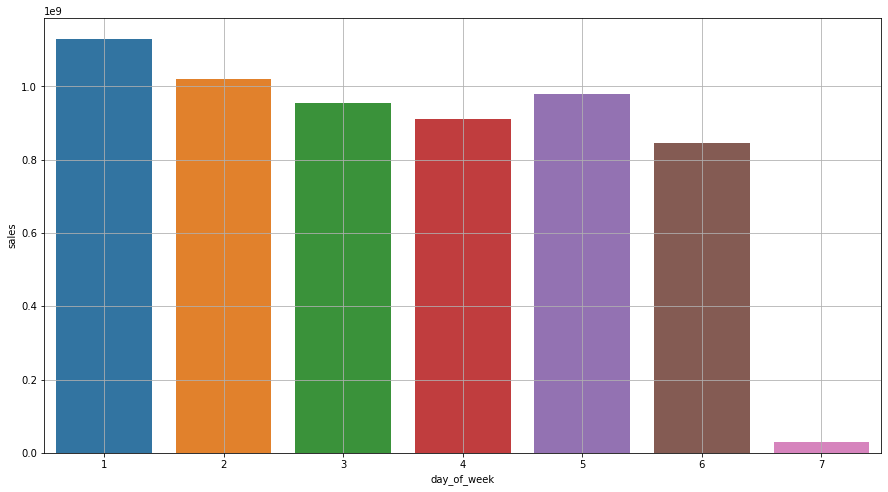

In [111]:
plt.figure(figsize = (15,8))
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1)
plt.grid();

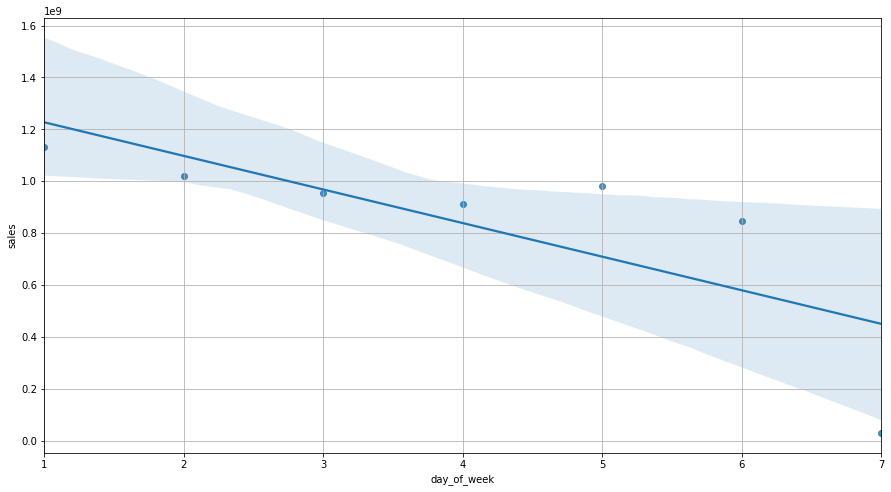

In [112]:
# regplot
plt.figure(figsize = (15,8))
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1)
plt.grid();

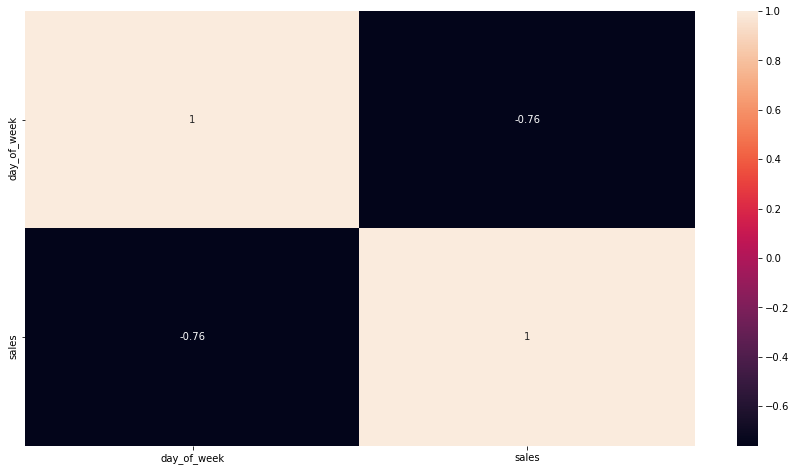

In [113]:
# heatmap
plt.figure(figsize = (15,8))
sns.heatmap(aux1.corr(), annot = True);

<b><u> CONCLUSÃO: </u></b>

<b>Lojas vendem menos nos finais de semana</b>. Assim, <b>validamos</b> essa hipótese.

## Análise Multivariada

Nessa etapa, o objetivo é encontrar não só as correlações e impacto entre as variáveis independentes e a variável target, mas também as correlações entre as próprias variáveis independentes.

A motivação da análise multivariada é, entre outros motivos, pela teoria da Navalha de Occam. Ela preza, basicamente, pela parcimônia na solução de um problema, onde entre várias soluções, extraídas em condições parecidas, a mais simples e de menor complexidade deve ser a mais racional. 

Essa teoria é aplicada à modelos de Machine Learning, pois o melhor modelo é aquele com menor complexidade, onde esse tem mais chances de melhor generalização.

Uma forma de deixar um modelo mais complexo tem haver com a dimensionalidade (basicamente, o número de colunas do dataset). Quanto maior a dimensionalidade, mais complexo é o modelo.

Para reduzir a dimensionalidade podemos simplismente retirar colunas do dataset, de acordo com critérios. Um desses critérios é o quanto de informação cada coluna carrega. Como exemplo, podemos ter 2 colunas que carregam a mesma informação e, com a retirada de uma delas do dataset, não temos perda de informação. 

E como encontramos as variáveis que possuem o mesmo nível de informação? Através dos Vetores Linearmente Dependentes, onde, se tivermos 2 variáveis que são linearmente dependentes, podemos retirar uma delas e o conteúdo da informação se mantém. Uma forma de observar isso é através da própria correlação entre as variáveis, onde uma variável com correlação muita alta com outra pode se encaixar nesse critério.

A matriz de correlação é uma matriz simétrica, ou seja, se dividirmos na diagonal, cada parte é exatamente o espelho da outra. Em cada quadrado dessa diagonal podemos ver o valor máximo 1, que representa a correlação de uma variável com ela mesma.

O método "Pearson", utilizado acima, é um teste estatístico para definir a correlação entre duas variáveis numéricas. Quando temos variáveis categóricas utilizamos um teste estatístico chamado V de Cramer. Esse método possui apenas correlação positiva ou igual a 0, onde quanto mais perto de 1, maior é a correlação e, quanto mais perto de 0, menor é a correlação. Ele utiliza a fórmula abaixo, com seus elementos definidos logo abaixo:


<font color = 'gold'>aa

### Atributos numéricos

In [114]:
# head variáveis numéricas
atributos_numericos.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


In [115]:
# pegar correlação entre as variáveis (método de pearson)
corr = atributos_numericos.corr(method='pearson')

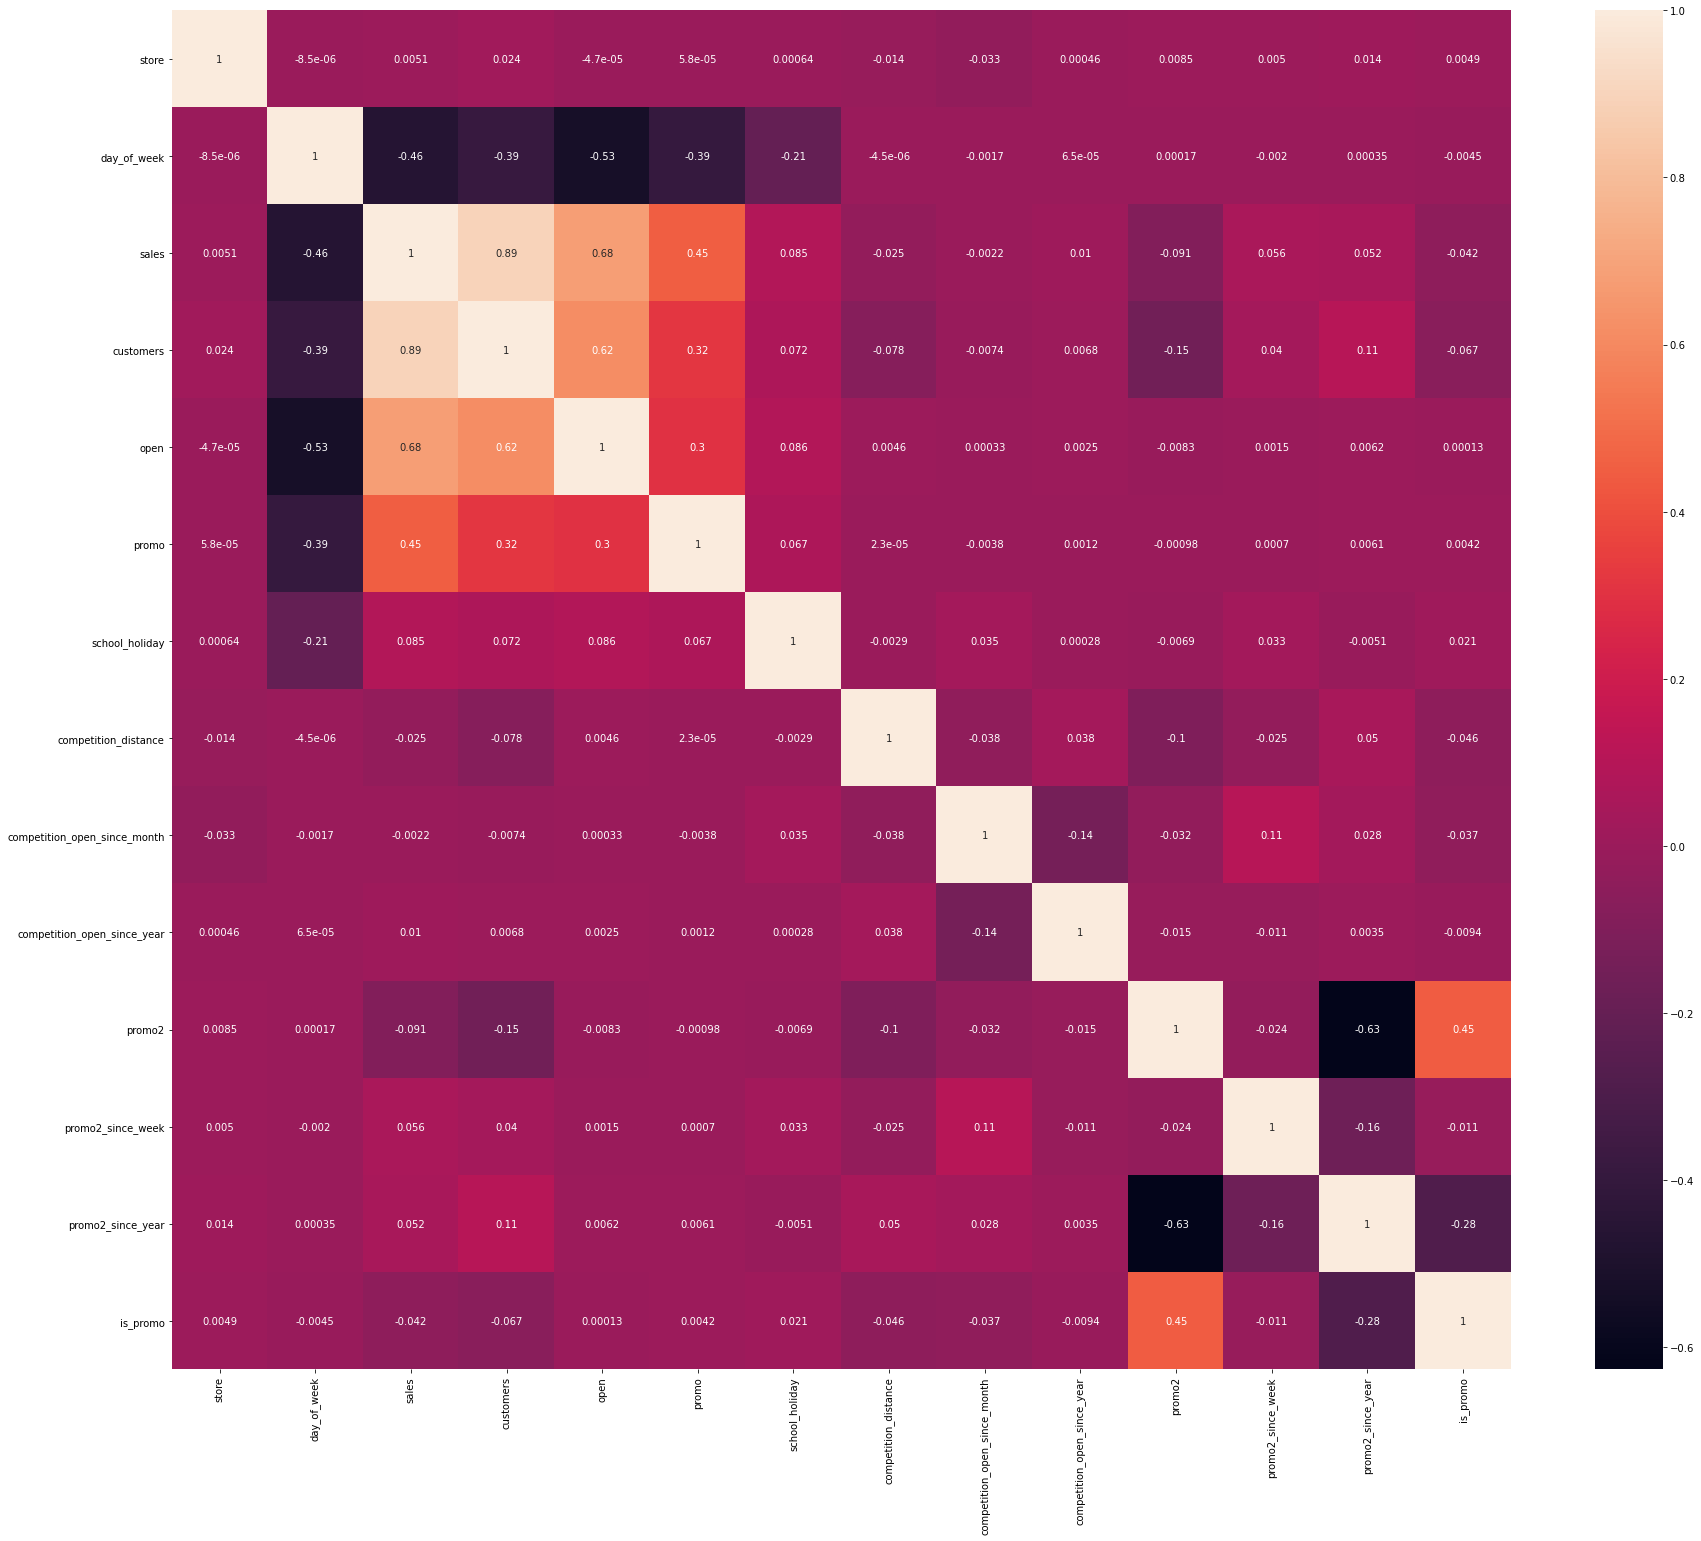

In [116]:
# heatmap
plt.figure(figsize = (30,25))
sns.heatmap(corr, annot = True);

Podemos perceber que a variável target "sales" possui alta correlação negativa com "day_of_week", além de alta correlação positiva com "customers", "open" e "promo", sendo que  "customers" não será utilizada pela falta da previsão do número de clientes nas lojas (seria necessário um projeto de maior complexidade ou separado para isso).

### Atributos categóricos

In [117]:
# selecionar novamente as colunas object

In [118]:
# head

In [119]:
# importar scipy

In [120]:
# criar tabela de contingencia entre state_holiday e store_type (como uma matriz)

In [121]:
# usar a tabela no chi2
#ss.chi2_contingency(cm)

O teste chi2 tem 4 resultados em um array: o primeiro é o resultado do teste chi2 baseado no método pearson; o segundo é o p-valor; o terceiro é o número de graus de liberdade; o quarto é uma tabela de frequência.

Por enquanto só estamos interessados no primeiro valor, que é o resultado do teste.

In [122]:
# pegar primeiro valor do chi2
#chi2 = ss.chi2_contingency(cm)[0]

In [123]:
# definir elementos da fórmula (r e k na mesma linha)

In [124]:
# definir a fórmula


<font color = 'gold'>BIAS CORRECTION

In [125]:
# formula da correção
# chi2_corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
# k_corr = k - (k-1)**2/(n-1)
# r_corr = r - (r-1)**2/(n-1)

In [126]:
# colocar esse cálculo dentro de uma função (retorno == fórmula)
#def v_cramer(x, y):
    
    
    
    #return np.sqrt((chi2_corr/n) / min(k_corr - 1, r_corr - 1))

In [127]:
# calcular a correlação entre as variáveis

In [128]:
# criar dataframe com os dados acima (utilizar dicionário)

In [129]:
# renomear indice

In [130]:
# heatmap

# PREPARAÇÃO DOS DADOS

Nessa etapa vamos modelar os dados para o treinamento de Machine Learning. Esse treinamento é facilitado <b>1) por dados numéricos</b> e <b>2) na mesma escala</b>.

<b>1)</b> A maioria dos algoritmos de ML foi criada seguindo alguns critérios. Entre eles, um critério exige que as variáveis sejam numéricas, pois a maioria desses algoritmos trabalha com métodos de otimização, que encontram os melhores parâmetros para o conjunto de dados. Esses métodos utilizam o conceito de derivadas, multiplicações, somas, etc. Isso não seria possível com variáveis categóricas. Sendo assim, um cientista de dados deve converter as variáveis categóricas em variáveis numéricas sem perder o conteúdo de informação. Isso se chama "encoding". 

<b>2)</b> Temos na coluna "day_of_week" números de 1 a 7. Já na coluna "competition_distance", temos valores com range muito maior, entre 20 e 199980,0. Isso mostra como as variáveis podem ser diferentes em certos aspectos. Os métodos de otimização dos algoritmos de ML trabalham com derivadas e essas derivadas "beneficiam" aquelas variáveis com maior range, tendendo a enviesar o modelo e dar um peso maior para elas. O que podemos fazer para que o algoritmo seja mais "justo" com as variáveis é normalizar as escalas, onde ele não "pensará" que uma variável é mais importante do que a outra.

E como preparar os dados?

Existem, basicamente, 3 tipos de preparação dos dados:

* <b>Normalização</b> ➜ Reescala o centro para 0  com desvio-padrão igual a 1; funciona para variáveis que possuem uma distribuição gaussiana.
    - https://www.kaggle.com/discdiver/guide-to-scaling-and-standardizing
* <b>Rescaling</b> ➜ Reescala para o intervalo entre 0 e 1; é muito útil para variáveis que não tem uma distribuição gaussiana
* <b>Transformação</b> ➜ possui 2 tipos:
    - Encoding: conversão de features categóricas para numéricas
    - transformação de natureza

In [131]:
# cópia do df
df5 = df4.copy()

## Normalização

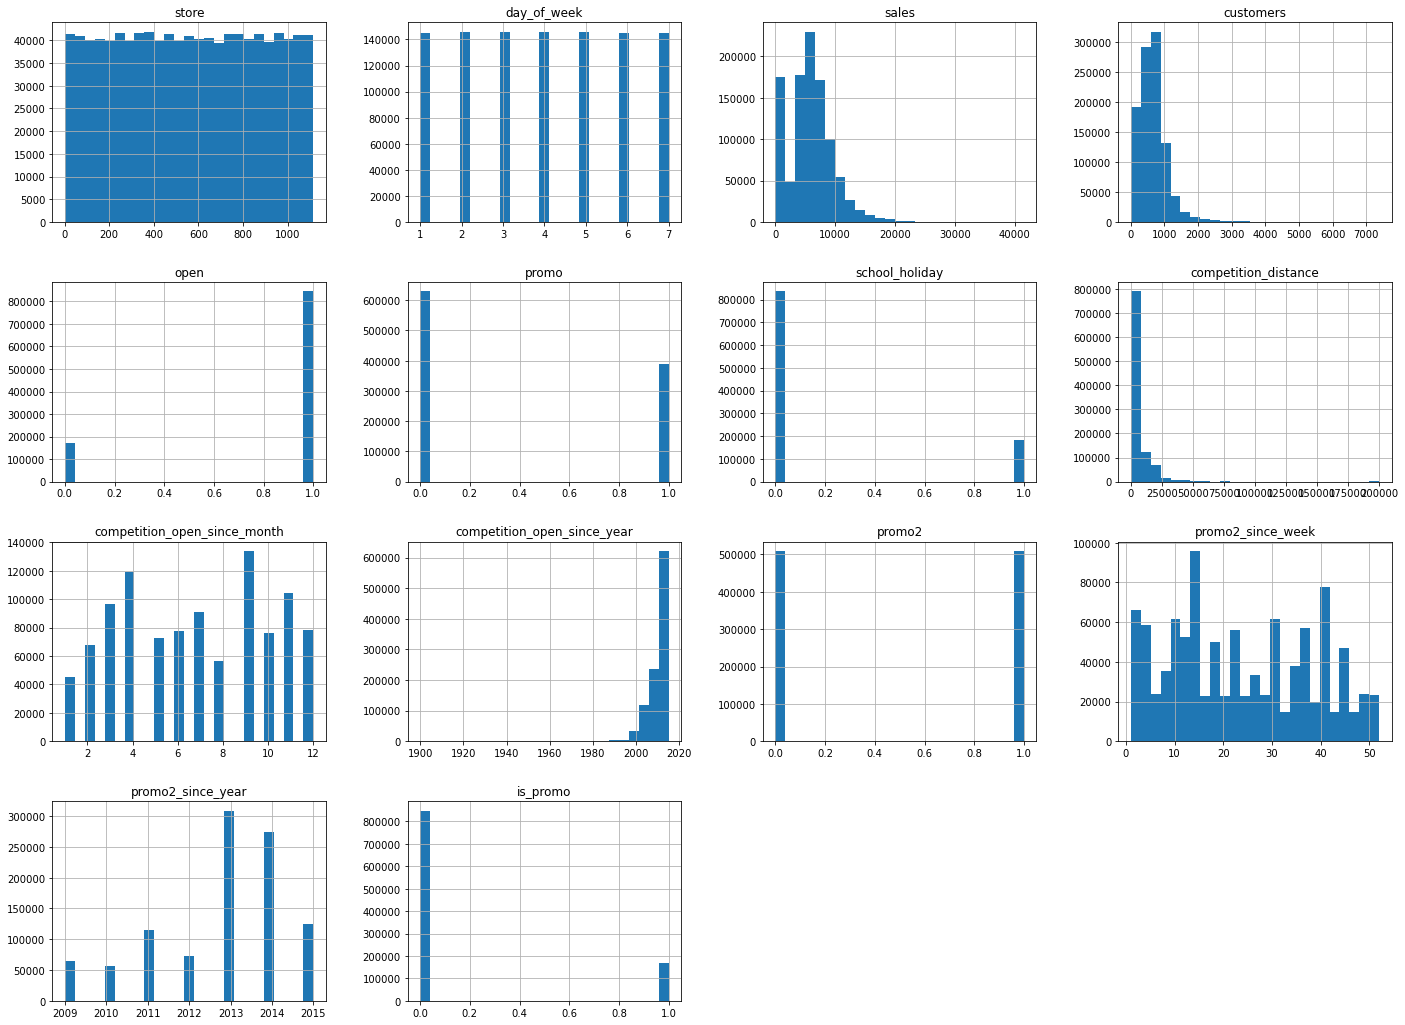

In [132]:
# olhar a distribuição dos dados numéricos
atributos_numericos.hist(bins = 25, figsize = (24,18));

Não temos distribuição normal entre essas variáveis númericas. Não faremos a normalização delas.

## Rescaling

Se temos dados que não possuem uma distribuição normal, a técnica de Rescaling é uma solução para acabar com a diferença muito grande de range.

Um método de Rescaling é o Min-Max Scaler. Ele não muda a natureza da distribuição da variável, mas apenas a sua escala. Seu problema é que ele é muito sensível para outliers, pois sua fórmula utiliza os valores mínimo e máximo daquela coluna e isso pode acabar deformando a distribuição. 

Uma opção para evitar os outliers no Rescaling é inserir na fórmula, no lugar dos valores mínimo e máximo, o intervalo interquartil, ou seja, o 3º quartil e o 1º quartil. Essa solução é implementada através do método Robust Scaler.

<b>Em resumo:</b> podemos utilizar o Min-Max Scaler nas variáveis que não possuem outliers muito fortes e utilizar o Robust Scaler nas variáveis que possuem outliers muito fortes.

In [133]:
# separar variáveis numéricas
a = df5.select_dtypes(include = ['int64', 'float64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,promo2,is_promo,year,month,day,week_of_year
0,1,5,5263,1,1,1270.0,0,0,2015,7,31,31
1,2,5,6064,1,1,570.0,1,1,2015,7,31,31
2,3,5,8314,1,1,14130.0,1,1,2015,7,31,31
3,4,5,13995,1,1,620.0,0,0,2015,7,31,31
4,5,5,4822,1,1,29910.0,0,0,2015,7,31,31


As variáveis onde aplicaremos o Rescaling serão:

* day of week
* competition distance
* year
* month
* day
* week of year
* competition time month
* promo time week

As variáveis que podemos considerar como cíclicas são "day of week", "day", "week of year", "month". A variável "Year" não é considerada cíclica pois os anos apenas progridem, não retornam a valores já "passados".

Precisamos agora verificar a existência de outliers ou não nas variáveis para decidirmos o método a ser utilizado. Podemos utilizar o Boxplot para essa verificação.

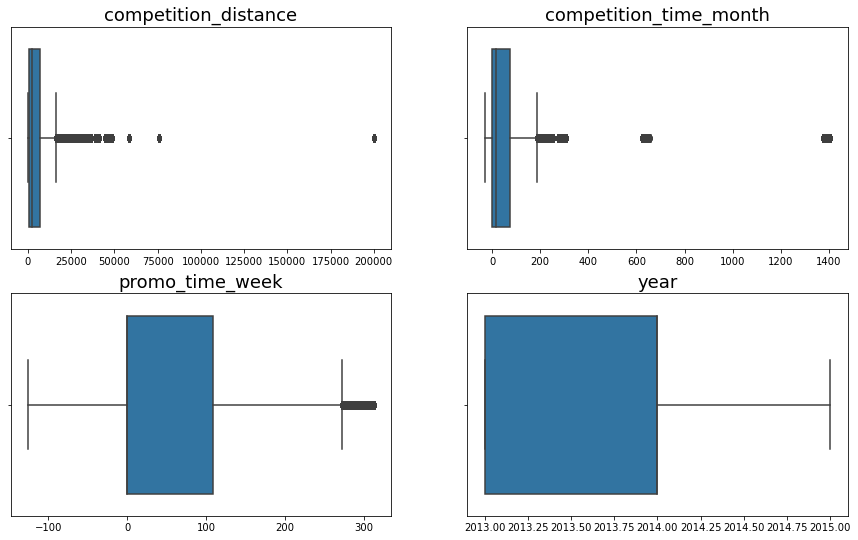

In [134]:
# boxplot competition distance
# fazer a mesma coisa para as outras
plt.figure(figsize = (15,9)) 

plt.subplot(2,2,1)
plt.title('competition_distance', fontdict={'fontsize': (18)})
sns.boxplot(df5['competition_distance'])
plt.xlabel('')

plt.subplot(2,2,2)
plt.title('competition_time_month', fontdict={'fontsize': (18)})
sns.boxplot(df5['competition_time_month'])
plt.xlabel('')

plt.subplot(2,2,3)
plt.title('promo_time_week', fontdict={'fontsize': (18)})
sns.boxplot(df5['promo_time_week'])
plt.xlabel('')

plt.subplot(2,2,4)
plt.title('year', fontdict={'fontsize': (18)})
sns.boxplot(df5['year'])
plt.xlabel('');

<b>RobustScaler</b>: competition_distance, competition_time_month

<b>MinMaxScaler</b>: promo_time_week, year

In [135]:
# instanciar RobustScaler e MinMaxScaler
rs = RobustScaler()
mms = MinMaxScaler()

A função fit_transform() encontra os parâmetros da fórmula e aplica aos dados. O método fit() apenas encontra os parâmetros para que possamos aplicar aos dados separadamente.

Abaixo são utilizadas funções criadas para reescalar os dados desejados.

In [136]:
# utilizar função criada para treinar e transformar/reescalar 
robust_scaler(df5, ['competition_distance', 'competition_time_month'])
min_max_scaler(df5, ['promo_time_week', 'year'])

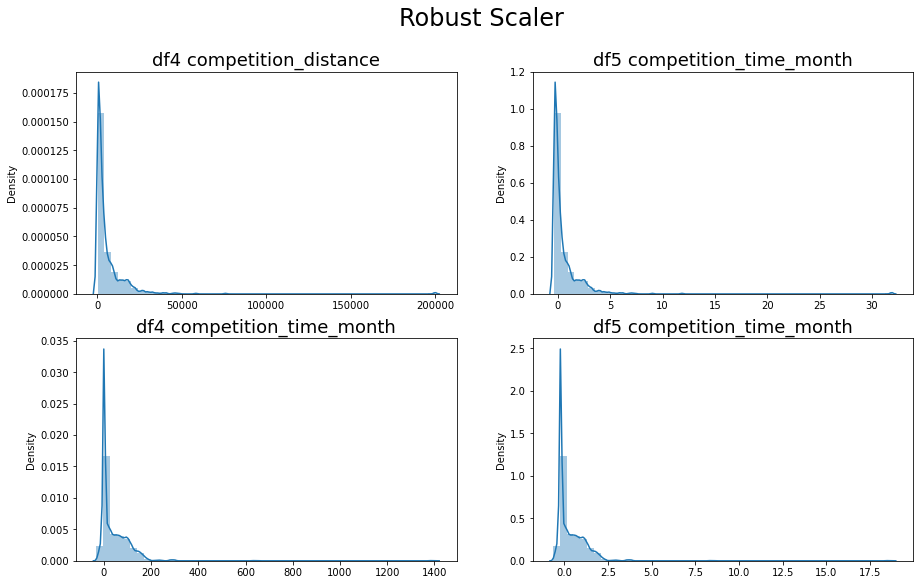

In [137]:
# verificar a diferença de escala das variáveis antes e depois de reescalar (dataframe e distplot)
plt.figure(figsize = (15,9)) 
plt.suptitle('Robust Scaler', fontsize = 24)

plt.subplot(2,2,1)
plt.title('df4 competition_distance', fontdict={'fontsize': (18)})
sns.distplot(df4['competition_distance'])
plt.xlabel('')

plt.subplot(2,2,2)
plt.title('df5 competition_time_month', fontdict={'fontsize': (18)})
sns.distplot(df5['competition_distance'])
plt.xlabel('')

plt.subplot(2,2,3)
plt.title('df4 competition_time_month', fontdict={'fontsize': (18)})
sns.distplot(df4['competition_time_month'])
plt.xlabel('')

plt.subplot(2,2,4)
plt.title('df5 competition_time_month', fontdict={'fontsize': (18)})
sns.distplot(df5['competition_time_month'])
plt.xlabel('');

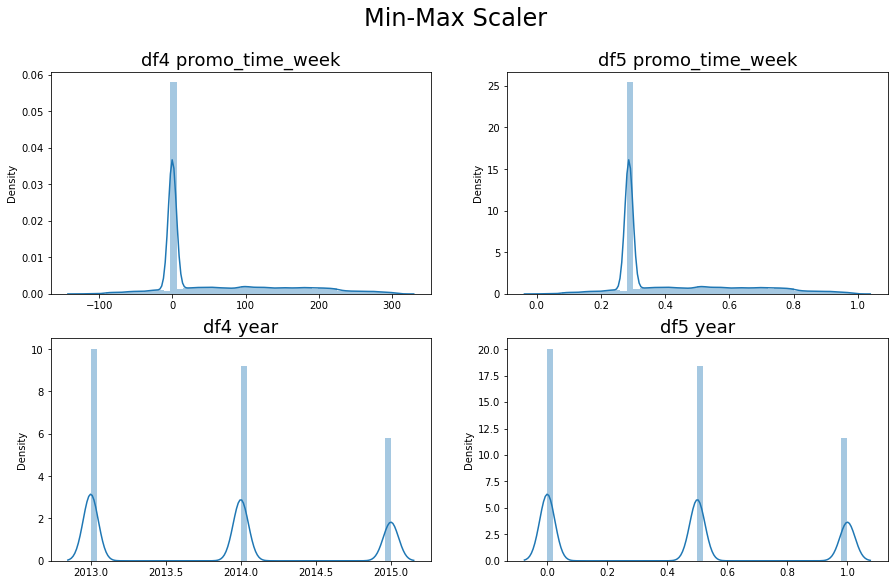

In [138]:
plt.figure(figsize = (15,9)) 
plt.suptitle('Min-Max Scaler', fontsize = 24)

plt.subplot(2,2,1)
plt.title('df4 promo_time_week', fontdict={'fontsize': (18)})
sns.distplot(df4['promo_time_week'])
plt.xlabel('')

plt.subplot(2,2,2)
plt.title('df5 promo_time_week', fontdict={'fontsize': (18)})
sns.distplot(df5['promo_time_week'])
plt.xlabel('')

plt.subplot(2,2,3)
plt.title('df4 year', fontdict={'fontsize': (18)})
sns.distplot(df4['year'])
plt.xlabel('')

plt.subplot(2,2,4)
plt.title('df5 year', fontdict={'fontsize': (18)})
sns.distplot(df5['year'])
plt.xlabel('');

Podemos perceber que as distribuições continuam iguais, apenas com as escalas diferentes, entre 0 e 1.

## Transformação

### Encoding

O melhor tipo de encoding depende dos dados nos quais estivermos trabalhando. Podemos ter um feeling dos dados na Análise exploratória. Também podemos testar quais tipos de Encoding nos trazem melhores resultados no modelo.

Alguns tipos de Encoding:
* <b>One Hot Encoding</b> ➜ criação de uma coluna para cada nível da variável que queremos. Se a linha for daquele tipo de nível, ela recebe 1. Caso contrário, recebe 0. Como vantagem, é fácil de aplicar. Como desvantagem, pode criar muitas colunas no dataset e levar ao Overfitting do modelo.
* <b>Label Encoding</b> ➜ trocar cada nível da variável desejada por um número. Funciona bem para variáveis que são apenas "nomes", sem ordem a ser respeitada. Ex: cores
* <b>Ordinal Encoding</b> ➜ parecido com o Label Encoding, porém seguindo alguma ordem. Ex: temperatura, níveis de graduação
* <b>Target Encoding</b> ➜ funciona quando temos muitos níveis na variável categórica. Calcula a média da variável para cada níveis que ela possui. Ou seja, utiliza uma relação entre a variável target e a variável onde será feito o Encoding. Essa média, então, substitui o valor na coluna.
* <b>Frequency Encoding</b> ➜ Parecido com o Target Encoding. Contudo, aqui é feita uma contagem em números absolutos ou porcentagem.
* <b>Embedding Encoding</b> ➜ É um método que já está implícito nas Redes Neurais profundas.São camadas que fazem a tradução da variável categórica para a variável numérica, tentando manter uma relação de distância dentro de um contexto. Muito usado em NLP. Ex: palavras que podem ser parecidas umas com as outras, dentro de um contexto.

Um ótimo artigo sobre Encoding está no link https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02.

In [139]:
# state_holiday - One Hot Encoding
# store_type - Label Encoding
# assorment - Ordinal Encoding (há um certo tipo de hierarquia)

In [140]:
df5['state_holiday'].unique()

array(['regular day', 'public holiday', 'Easter holiday', 'Christmas'],
      dtype=object)

In [141]:
# retirando os espaços dos valores da coluna state_holiday
df5['state_holiday'].replace(' ', '_', regex = True, inplace = True)

In [142]:
# state_holiday
# get_dummies
# prefix
# salvar no dataset
df5 = pd.get_dummies(df5, prefix = 'state_holiday', columns=['state_holiday'])

In [143]:
# instanciar LabelEncoder
le = LabelEncoder()

In [144]:
# store_type
# LabelEncoder
df5['store_type'] = le.fit_transform(df5['store_type'])

In [145]:
# unique assortment
df5['assortment'].unique()

array(['basic', 'extended', 'extra'], dtype=object)

In [146]:
# criar dicionário com os encodings para assortment
# fazer o encoding
dic = {'basic': 1,
      'extra': 2,
      'extended': 3}
df5['assortment'] = df5['assortment'].map(dic)

Nada impede que usemos o Target Encoding nas 3 variáveis. Apenas escolhemos abordagens diferentes para testar.

### Transformação de Grandeza e Transformação de Natureza

O objetivo da <b>Transformação de Grandeza</b> é trazer sua variável com uma distribuição mais próxima possível de uma normal. A causa dessa modificação é que modelos de Machine Learning possuem certas premissas, sendo uma delas que os dados sejam normalmente distribuidos. 



O objetivo da <b>Transformação de Natureza</b> é trazer a natureza real dos dados da variável dentro do conjunto de dados. Usado com dados "cíclicos". Ex: quando temos uma variável referente aos meses do ano, seus níveis são de 1 a 12. Sendo assim, o mês 1 (Janeiro) está muito perto do mês 3 (Março), porém muito longe do mês 12 (Dezembro). Contudo, o mês 12 está muito mais próximo do mês 1 do ano seguinte. Essa relação também tem o seu valor e a Transformação de Natureza visa manter essa relação.

<b>Alguns tipos de Transformação de Natureza:</b>
* <b>Transformação logarítmica</b> ➜ transforma distribuições que possuem uma Skew muito à direita ou muito à esquerda em uma distribuição mais próxima de uma normal. Basicamente, é a multiplicação de todos os valores da variável pelo log.
* <b>Transformação Box-Cox</b> ➜ mesma função da Transformação Logarítmica, porém com uma fórmula específica. 
* <b>Transformação Cube-Root</b> ➜ mesma função das outras tranformações, porém com a extração da raiz cúbica de todos os valores.
* <b>Transformação Square-Root</b> ➜ mesma função das outras tranformações, porém com a extração da raiz quadrada de todos os valores.

Será utilizada a Transformação Logarítmica.

#### Transformação da variável target

In [147]:
# log1p
# reescrever a variável target
df5['sales'] = np.log1p(df5['sales'])

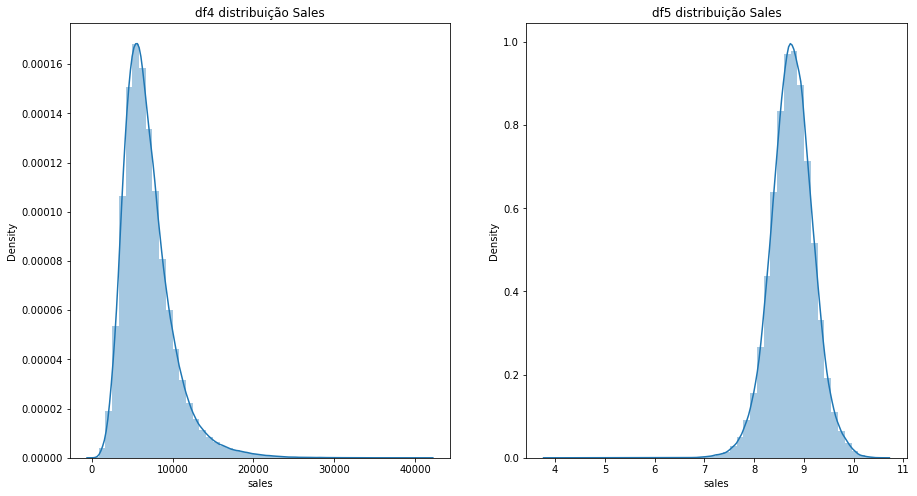

In [148]:
# comparar distribuições de sales em df4 e df5
plt.figure(figsize = (15,8))

plt.subplot(1,2,1)
plt.title('df4 distribuição Sales')
sns.distplot(df4['sales'])

plt.subplot(1,2,2)
plt.title('df5 distribuição Sales')
sns.distplot(df5['sales']);

Podemos verificar que, multiplicando os valores da variável target "sales" pelo log, utilizando a função log1p do Numpy, a sua distribuição passou a ficar próxima de uma normal.

#### Transformação de Natureza Cíclica

Aqui vamos transformar as variáveis "cíclicas":

* day of week
* day
* week of year
* month

In [149]:
# criar novas colunas para cada variável cíclica, com seno e cosseno: np.sin(x * (2. * np.pi / 12))

# dias na semana == 7
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))

# dias no mês == 30
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

# semanas no ano == 52
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))

# meses do ano == 12
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

# FEATURE SELECTION

In [150]:
# cópia do df
df6 = df5.copy()

<b><u>A motivação da Seleção de variáveis</u></b>

A seleção de variáveis vai de encontro à um dos princípios da aprendizagem estatística, o princípio de Occam's Razor, que garante o aprendizado dos modelos. Sua descrição é: "A explicação mais simples sobre um fenômeno observado deveria prevalecer sobre explicações mais complexas.". Isso se aplica aos modelos de Machine Learning. Se você tiver alguns modelos, dê preferência ao mais simples, pois provavelmente ele vai generalizar melhor os dados que receber.

Para tornarmos a aprendizagem de máquina mais simples, então, precisamos utilizar modelos mais simples. Esses modelos mais simples tendem a aprender melhor com um conjunto de dados mais simples. E a simplicidade do conjunto de dados está na quantidade de colunas que ele tem.

Para deixarmos o conjunto de dados mais simples, podemos verificar se existem variáveis que explicam a mesma parte do fenômeno que será explorado pelo modelo, ou seja, variáveis que carregam conteúdos de informação parecidos. Essas variáveis são chamadas de <b>Colineares</b>. A remoção dessas variáveis tende a melhorar a performance do modelo.

## Tipos de Seleção de variáveis

<b><u>Seleção Univariada (Filter Methods)</u></b> ➜ classifica as variáveis como relevantes ou não relevantes para o modelo. Ou seja, esse método tenta encontrar, entre todas as variáveis do dataset, quais delas explicam a maior porção do fenômeno (vendas). 
    - Esse método pega emprestado um conceito de estatística chamado Coeficiente de correlação, que é basicamente aquele que vimos na Análise Exploratória dos Dados. Com ele, o método de Seleção Univariada  considera como relevantes as variáveis que possuem alta correlação (quanto mais perto de -1 ou 1) com a variável target e como não relevantes aquelas com correlação fraca com a variável target (quanto mais perto de 0).
    - Vantagem: É um método fácil, simples e de fácil entendimento
    - Desvantagem: Não considera a influência/correlação entre variáveis independentes juntas e a variável target. Uma variável e sua correlação com a variável target analisada isoladamente pode ser fraca, porém se ela fosse analisada em conjunto com outras variáveis, poderia apresentar uma correlação relevante.
    - Quando formos verificar a correlação entre duas variáveis (categóricas e/ou numéricas), temos um método estatístico para aplicar, dependendo do tipo das variáveis:

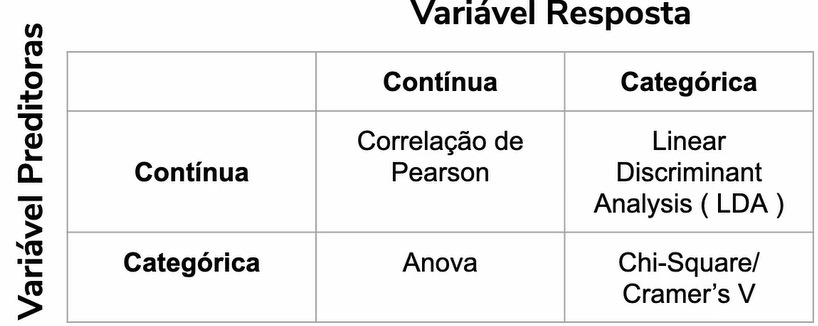

<b><u>Seleção por importância (Método embutido)</u></b> ➜ esse método é um subproduto do próprio sistema de aprendizado de alguns algoritmos de ML. 

Exemplo: o algoritmo Random Forest serve tanto para classificação quanto para regressão. Para criar a melhor estrutura da árvore, o próprio modelo seleciona as variáveis mais importantes para isso. Daí vem os seus nomes.

O Random Forest utiliza um método chamado Gini Impurity. O algoritmo vai selecionando as variáveis e vai dividindo o conjunto de dados original em dois grupos o mais homogêneos (similares) possível, ou seja, com baixo grau de impureza. Caso consiga fazer isso, essa variável que separou os dois conjuntos é considerada como uma variável importante. Não satisfeito, o algoritmo vai abrindo novas ramificações e verificando sua importância de outras variáveis em conjunto com a variável acima delas na árvore.

Na prática, isso é feito pegando o conjunto de dados de treino (todas as colunas + a variável resposta), treinar o algoritmo Random Forest e pegar um dos seus resultados, que representa a importância de cada uma das variáveis. Podemos, inclusive, plotar um gráfico com essas importâncias.

Outros algoritmos também fazem esse tipo de seleção, como algoritmos de regressão, como o Lasso Regression e o Ridge Regression. Esses algoritmos atribuem um peso desconhecido para cada variável. O algoritmo tem a função de encontrar esses pesos dados para cada uma das variáveis. Variáveis com peso alto são, muito provavelmente, importantes para o aprendizado do modelo. Esses dois algoritmos são regularizados, ou seja, utilizam algumas "artimanhas" matemáticas para fazer com que seus pesos fiquem dentro de um range para que não fiquem muito grandes ou muito pequenos. 

O forma de utilização é parecida com Random Forest. Contudo os resultados que veremos e podemos plotar são pesos dados às variáveis, onde são mais relevantes as mais próximas de 1 e de -1, sendo as mais próximas de 0 as menos relevantes.

<b><u>Seleção por subset (Wrapper method)</u></b> ➜ é método possui conceitos diferentes dos dois anteriores. Aqui há uma sequência de passos para determinar a relevância das variáveis.

O primeiro passo é selecionar, aleatoriamente, uma variável do dataset limpo. Com essa variável, juntamente com a variável resposta, devemos treinar o algoritmo de ML. Após o modelo treinado, calculados a performance desse modelo, em termos de acurácia ou de erro. Após esse processo, fazemos uma pergunta: a performance aumentou, em comparação com a anterior (a primeira execução dessa sequência é o nosso baseline)?

O segundo passo é praticamente repetir o primeiro. Selecionamos uma nova variável, aleatoriamente, e juntamos ao dataset para treino. Agora teríamos 2 variáveis independentes e a variável resposta para o treino. Então, após a sequência de passou, perguntamos novamente. A performance aumentou, em comparação com a anterior? Caso a resposta seja sim, mantemos a variável, temos um novo baseline e seguimos para adicionar uma nova variável aleatória. Caso a resposta seja não, essa variável deve ser removida e voltamos para o fluxo de passos. No final, teríamos um dataset com as variáveis mais relevantes.

Esse processo não precisa ser feito manualmente, pois há algoritmos prontos que fazem o serviço, bastando passar o conjunto de dados original e ele nos devolve as variáveis mais importantes. O algoritmo Boruta funciona com esse tipo de Feature Engineering.

<b>Boruta</b>

A primeira coisa que o Boruta faz é ir no conjunto de dados original e selecionar duas variáveis aleatórias. Após isso, ele cria as chamadas variáveis "shadow" (Shadow Features), que são, basicamente, cópias das variáveis originais com as linhas misturadas, embaralhadas. Essa mistura é feita para remover a correlação entre essas variáveis e as originais. Esse novo conjunto de dados (com as variáveis originais e as shadow) é utilizado para treinar o modelo (por exemplo, Random Forest, XGBoost). Após treinar o modelo, o Boruta mostra a importância de cada uma dessas variáveis. Então ele compara a variável shadow com maior importância com cada uma das variáveis originais e cria uma tabela, conhecida como "tabela de casos de sucesso" ou "sucess counts". Caso o valor de importância da variável original comparada seja maior do que a shadow de maior desempenho, o algoritmo marca o valor 1 em sua tabela. Caso contrário, marca o valor 0. Esse processo é repetido embaralhando várias vezes as variáveis shadow, aumentando a tabela. É então calculado o p-valor de cada uma delas para comparação com o limite, para dizer se a variável é relevante ou não para ser utilizada no treinamento do modelo. Isso é feito para todas as variáveis do dataset.

## Divisão do dataset em treino e teste

Na etapa de Feature Engineering nós derivamos algumas variáveis a partir da variável original. Devemos excluir as variáveis originais. 

In [151]:
# cols_drop com as variáveis a excluir
# week_of_year, day_of_week, day, month, promo_since, competition_since, year_week
cols_drop = ['week_of_year', 'day_of_week', 'day', 'month', 'promo_since', 'competition_since', 'year_week']
df6.drop(cols_drop, axis = 1, inplace = True)

Agora vamos dividir o dataset em treino e teste. Os dados de treino serão usados para treinar/ajustar o modelo e os dados de teste, que não foram vistos por esse modelo, serão usados para que ele tente encontrar seus resultados, e então poderemos verificar a sua eficácia. 

Em relação a dados temporais, não podemos selecionar aleatoriamente os dados que pertencem ao treino e pertencem ao teste, pois podemos pegar dados futuros e dados passados e misturá-los nessa divisão. Se isso acontecesse, há grande chance de que ocorresse um Overfitting, pois o modelo aprenderia com os dados futuros e já teria o conhecimento na mão.

Nesse projeto queremos prever as vendas das próximas 6 semanas (dados que não existem no dataset). É razoável, então, que utilizemos as últimas 6 semanas presentes no dataset para os dados de teste e o renstante, antes desse período, para treino.

In [152]:
# verificar a primeira data das vendas das lojas
# pegar loja e data, agrupados por loja
df6[['date', 'store']].groupby('store').min().reset_index()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
...,...,...
1110,1111,2013-01-02
1111,1112,2013-01-02
1112,1113,2013-01-02
1113,1114,2013-01-02


In [153]:
# verificar a última data das vendas das lojas
# pegar loja e data, agrupados por loja
max_venda = df6[['date', 'store']].groupby('store').max().reset_index().loc[0].date
max_venda

Timestamp('2015-07-31 00:00:00')

In [154]:
# usando os dados da última data de venda, subtrair 6 semanas
# importar timedelta
# pegar a data
data_treino = max_venda - datetime.timedelta(days = 7*6)
data_treino

Timestamp('2015-06-19 00:00:00')

In [155]:
# pegar todos os dados antes da data acima para treino (X_treino, y_treino(sales)) e 
# depois dessa data para teste
X_treino = df6[df6['date'] < data_treino]
y_treino = X_treino['sales']

X_teste = df6[df6['date'] >= data_treino]
y_teste = X_teste['sales']

In [156]:
# printar valores min e max de date em treino e teste
print(f'Min date em treino: {X_treino.date.min()}')
print(f'Max date em treino: {X_treino.date.max()}')

print(f'Min date em treino: {X_teste.date.min()}')
print(f'Max date em treino: {X_teste.date.max()}')

Min date em treino: 2013-01-01 00:00:00
Max date em treino: 2015-06-18 00:00:00
Min date em treino: 2015-06-19 00:00:00
Max date em treino: 2015-07-31 00:00:00


## Boruta como seletor de variáveis

In [157]:
# instanciar random forest (n_jobs = -1 para que ele use todos os cores da maquina e processe em paralelo)
rf = RandomForestRegressor(n_jobs = -1)

In [158]:
# instanciar BorutaPy com Random Forest, estimadores = auto, verbose 2 e random_state 42)
boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42) 

O Boruta não aceita dataframes para treinar o modelo, mas arrays Numpy. Então devemos modificar os datasets criados.

Vamos também excluir as variáveis "date" e "sales".

In [190]:
# novos dados do X_treino, dropando date e sales. Pegar apenas os valores
# mesma coisa para os dados de y_treino(ravel)
X_treino_boruta = X_treino.drop(['date', 'sales'], axis = 1).values
y_treino_boruta = y_treino.ravel()

In [160]:
# treinar/ajustar boruta com os novos dados de treino
boruta.fit(X_treino_boruta, y_treino_boruta)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy(estimator=RandomForestRegressor(n_estimators=73, n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x1A598B47C40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1A598B47C40, verbose=2)

## Melhores variáveis do Boruta

Após o treinamento/ajuste, utilizaremos as variáveis que o Boruta ranqueou como as mais importantes. A função support_ nos mostra esse ranking.

In [191]:
# pegar colunas selecionadas no ranking do boruta
# transformar em lista
cols_final = boruta.support_.tolist()

In [192]:
# criar novamente dados de treino sem date e sales
# ver os nomes das colunas, utilizando os dados de treino (todas as linhas, apenas as colunas do ranking)
# pegar apenas os nomes das colunas e transformar em uma lista
X_treino_novo = X_treino.drop(['date', 'sales'], axis = 1)
#cols_final = ['store','promo','store_type','assortment','competition_distance',
            #  'competition_open_since_month','competition_open_since_year','promo2', 'promo2_since_week',
            #  'promo2_since_year','competition_time_month','promo_time_week','day_of_week_sin',
            #  'day_of_week_cos', 'day_sin', 'day_cos', 'month_cos', 'week_of_year_sin']
cols_final = X_treino_novo.iloc[:, cols_final].columns.tolist()
#cols_final = X_treino_novo.loc[:, cols_final].columns.tolist()
cols_final

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'month_cos']

In [164]:
# fazer a comparação entre as selecionadas pelo boruta e o dataset de treino, para saber quais não foram
# selecionadas
print('Colunas que não foram selecionadas pelo Boruta: ')
list(np.setdiff1d(X_treino_novo.columns, cols_final))

Colunas que não foram selecionadas pelo Boruta: 


['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_Christmas',
 'state_holiday_Easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

Após o ranqueamento feito pelo Boruta, podemos compará-lo com os resultados das hipóteses que criamos anteriormente, na etapa de Análise Exploratória.

Por exemplo: o Boruta não considerou a variável "month_sin", referente ao seno do mês, como relevante. Contudo, ela foi considerada relevante na análise exploratória. Dessa forma, podemos incluir entre as selecionadas.

Já a variável "week_of_year_cos" também não foi considerada relevante pelo Boruta, mas foi na análise exploratória.

Caso a performance do modelo de regressão não seja satisfatória, podemos refazer o ciclo e incluir outras variáveis, além das escolhidas pelo Boruta.

Precisamos também incluir novamente as variáveis "date" e "sales". "date" será usada para separar os dados novamente e "sales" para o treinamento e teste.

In [193]:
# salvar em uma lista as colunas selecionadas pelo boruta e as que decidimos incluir
cols_analise_exp = ['month_sin']
cols_final.extend(cols_analise_exp)

In [194]:
# variáveis à adicionar(date, sales)
# usar extend() para unir as colunas finais
cols_add = ['date', 'sales']
cols_final.extend(cols_add)

# MODELAGEM DE MACHINE LEARNING

* <b>Modelo de média (Average Model)</b>➜ inserimos os dados de entrada e o modelo prevê a média. Sua intenção não é prever as vendas, mas sim ser um baseline para comparação para a performance dos outros modelos. 

* <b>Modelo de Regressão Linear (Linear Regression)</b>➜ 

* <b>Modelo de Regressão Linear Regularizado (Linear Regression Regularized)</b>➜ 

* <b>Random Forest Regressor</b>➜ 

* <b>XGBoost Regressor</b>➜ 

In [195]:
# x_treino com colunas do boruta
x_treino = X_treino[cols_final].drop(['sales', 'date'], axis = 1)
x_teste = X_teste[cols_final].drop(['sales', 'date'], axis = 1)

## Average Model

In [168]:
# criar variável aux1 com cópia de x_test
# inserir y_test (vendas) em aux1
aux1 = x_teste.copy()
aux1['sales'] = y_teste.copy()

A média será extraída do agrupamento das vendas por loja.

In [169]:
# aux2: media de vendas das lojas, agrupada por loja
# renomear "sales" para "predictions"
# juntar aux1 e aux2 (how, on) em aux1
# criar yhat_baseline (aux1['predictions'])
aux2 = aux1[['sales', 'store']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store')
yhat_baseline = aux1['predictions']

Para verficar a performance do modelo, devemos retornar os dados para sua escala normal, pois fizemos a transformação utilizando logaritmo.

In [170]:
# performance:
baseline_model = ml_error('Modelo de média', np.expm1(y_teste), np.expm1(yhat_baseline))
baseline_model

,Modelo,mae,mape,rmse
0,Modelo de média,1354.800353,0.455051,1835.135542


## Regressão Linear

In [171]:
lr = LinearRegression()

In [172]:
lr.fit(x_treino, y_treino)

LinearRegression()

In [173]:
yhat_lr = lr.predict(x_teste)

In [174]:
lr_resultado = ml_error('Regressão Linear', np.expm1(y_teste), np.expm1(yhat_lr))
lr_resultado

,Modelo,mae,mape,rmse
0,Regressão Linear,1868.313299,0.292392,2674.576594


## Regressão Linear Regularizada (Lasso)

LASSO: (parâmetro alpha multiplica todos os pesos. Dependendo desse resultado, ele pode aumentar ou diminuir esse peso. alpha é o fator multiplicativo para restringir o range onde os valores ficarão).

In [175]:
lrr = Lasso(alpha = 0.01)

In [176]:
lrr.fit(x_treino, y_treino)

Lasso(alpha=0.01)

In [177]:
yhat_lrr = lrr.predict(x_teste)

In [178]:
lrr_resultado = ml_error('Lasso', np.expm1(y_teste), np.expm1(yhat_lrr))
lrr_resultado

,Modelo,mae,mape,rmse
0,Lasso,1891.704881,0.289106,2744.45174


Os modelos lineares tiveram performance pior do que o modelo baseline de média. Isso mostra que nós temos um fenômeno que não é linear, nem simples. Logo, modelos lineares e mais simples não vão conseguir aprender o comportamento dos dados. Modelos não lineares podem aprender mais sobre esse comportamento, nesses casos.

## Random Forest Regressor

In [179]:
# instanciar Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)

In [180]:
# treinar
rf.fit(x_treino, y_treino)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [181]:
# predizer
rf_yhat = rf.predict(x_teste)

In [182]:
# utilizar função de métricas
rf_resultado = ml_error('Random Forest Regressor', np.expm1(y_teste), np.expm1(rf_yhat))
rf_resultado

,Modelo,mae,mape,rmse
0,Random Forest Regressor,696.287911,0.103383,1029.996182


## XGBoost Regressor

In [196]:
# XGBRegressor
# parametros: objective, n_estimators: 100, eta: 0.01, max_depth: 10, subsample: 0.7, col_sample...:0.9,
# são parâmetros default
xgb = XGBRegressor(objective='reg:squarederror', n_estimators = 100, eta = 0.01, max_depth = 10, 
                   subsample = 0.7, 
                   colsample_bytree = 0.9)

In [197]:
# treinar
xgb.fit(x_treino, y_treino)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, eta=0.01, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.00999999978, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [198]:
# predizer
yhat_xgb = xgb.predict(x_teste)

In [199]:
# função de métricas
# utilizar função de métricas
xgb_resultado = ml_error('XGBoostRegressor', np.expm1(y_teste), np.expm1(yhat_xgb))
xgb_resultado

,Modelo,mae,mape,rmse
0,XGBoostRegressor,6682.457738,0.949307,7329.740575


## Comparação da performance dos modelos

In [200]:
# concatenar todas as variáveis com os resultados
# ordenar pelo RMSE
dataframe_resultados = pd.concat([baseline_model, lr_resultado, lrr_resultado, rf_resultado, xgb_resultado])
dataframe_resultados.sort_values('rmse')

,Modelo,mae,mape,rmse
0,Random Forest Regressor,696.287911,0.103383,1029.996182
0,Modelo de média,1354.800353,0.455051,1835.135542
0,Regressão Linear,1868.313299,0.292392,2674.576594
0,Lasso,1891.704881,0.289106,2744.451740
0,XGBoostRegressor,6682.457738,0.949307,7329.740575


In [ ]:
# colorir o dataframe

O RMSE acima não é a métrica real para avaliação de performance de um modelo. Nós separamos os dados em teste (6 últimas semanas) e treino (o restante dos dados). Vamos supor que a última semana dos dados de teste possuem os dados mais comportados possível. Nesse caso, o modelo performa bem sobre esses dados. Mas vamos supor também que a semana anterior possui dados muito aleatórios. Isso reduz a performance do modelo. Para isso podemos utilizar o conceito de <b>Cross-Validation</b>, que divide os dados de treino em várias fatias e utiliza uma para teste. Todas as fatias são, em algum momento, dados de teste. No final, é feita uma média da performance em todas essas etapas essa média será a performance real do modelo.

## Cross-Validation

Para pegar toda a variabilidade que o fenômeno possui, precisamos medir a performance do modelo sobre vários intervalos em um mesmo conjunto de dados. 

Esse conceito tem, basicamente, duas formas de aplicação: para regressão e para classificação. Contudo, há também o Cross-validation para Séries Temporais, em que há uma pequena (mas essencial) diferença. Vamos à explicação para os dois primeiros!

Como dito anteriormente, a técnica de <b>Cross-Validation</b> divide o dataset em várias partes para que a performance do modelo seja realmente avaliada. Essa divisão é feita após a separação dos dados em treino e teste. Deixamos, então, os dados de teste "de lado", enquanto a validação cruzada ocorre em cima dos dados de treino. Esses dados são, então separados novamente. Podemos imaginar fatias, onde haverá uma fatia para validação da performance e o resto das fatias para treino do modelo. Esse processo é repetido alterando a fatia de validação para uma das de treino anteriores. Dessa forma, todas as fatias são, em algum momento, utilizadas para a validação e assim garantimos a aleatoriedade no treinamento e na validação dos dados.

A performance real do modelo é extraída do cálculo da média dos erros mais ou menos o desvio padrão desses mesmo erros.

A técnica de Cross-validation para Séries Temporais é um pouco diferente, pois precisamos dos dados na ordem cronológica e a aplicação de aleatoriedade quebraria essa "linha do tempo". 

A implementação de cross-validation nas séries temporais é feita da seguinte forma: pega-se uma parte dos dados, de acordo com o tempo e até certo ponto, e faz-se o treinamento do modelo. Uma parte posterior e do mesmo tamanho é utilizada para validação. Depois, é selecionada uma parte maior para treinamento (geralmente o dobro da primeira parte) e uma parte posterior para validação (geralmente do tamanho da primeira) e assim sucessivamente.

A conjunto de dados X_treino possui as variáveis "date" e "sales". Precisaremos delas agora.

Para aumento do período de treino e para pegar a parte posterior para validação, basta alterarmos o valor do tamanho na multiplicação de timedelta. Conforme formos aumentando o valor, teremos porções maiores para treino na validação cruzada. Pode então nomear esse valor de "k", sendo ele um KFold manual para esse processo.

In [201]:
# criar x_training, ytraining, x_validation e y_validation
xtreino = X_treino[cols_final]

### Performance real - comparação com resultados com Cross-Validation

#### Regressão Linear

In [202]:
lr_resultado_cv = cross_validation_series_temporais(5, xtreino, 'Regressão Linear', lr, verbose = True)
lr_resultado_cv

Número do KFold: 5
Número do KFold: 4
Número do KFold: 3
Número do KFold: 2
Número do KFold: 1


,Nome do modelo,MAE,MAPE,RSME
0,Regressão Linear,2080.69 + ou - 293.36,0.3 + ou - 0.02,2950.49 + ou - 464.71


#### Lasso

In [203]:
lrr_resultado_cv = cross_validation_series_temporais(5, xtreino, 'Lasso', lrr, verbose = True)
lrr_resultado_cv

Número do KFold: 5
Número do KFold: 4
Número do KFold: 3
Número do KFold: 2
Número do KFold: 1


,Nome do modelo,MAE,MAPE,RSME
0,Lasso,2116.38 + ou - 341.5,0.29 + ou - 0.01,3057.75 + ou - 504.26


#### Random Forest Regression

In [204]:
rf_resultado_cv = cross_validation_series_temporais(5, xtreino, 'Random Forest Regressor', 
                                                    rf, verbose = True)
rf_resultado_cv

Número do KFold: 5
Número do KFold: 4
Número do KFold: 3
Número do KFold: 2
Número do KFold: 1


,Nome do modelo,MAE,MAPE,RSME
0,Random Forest Regressor,838.71 + ou - 217.72,0.12 + ou - 0.02,1257.03 + ou - 318.56


#### XGBoost

In [205]:
xgb_resultado_cv = cross_validation_series_temporais(5, xtreino, 'XGBoost', 
                                                     xgb, verbose = True)
xgb_resultado_cv

Número do KFold: 5
Número do KFold: 4
Número do KFold: 3
Número do KFold: 2
Número do KFold: 1


,Nome do modelo,MAE,MAPE,RSME
0,XGBoost,7049.18 + ou - 588.36,0.95 + ou - 0.0,7715.21 + ou - 689.18


#### Dataframes  com as performances

In [206]:
pd.concat([lr_resultado_cv, lrr_resultado_cv, rf_resultado_cv, xgb_resultado_cv])

,Nome do modelo,MAE,MAPE,RSME
0,Regressão Linear,2080.69 + ou - 293.36,0.3 + ou - 0.02,2950.49 + ou - 464.71
0,Lasso,2116.38 + ou - 341.5,0.29 + ou - 0.01,3057.75 + ou - 504.26
0,Random Forest Regressor,838.71 + ou - 217.72,0.12 + ou - 0.02,1257.03 + ou - 318.56
0,XGBoost,7049.18 + ou - 588.36,0.95 + ou - 0.0,7715.21 + ou - 689.18


EXPLICAÇÃO

## Conclusão

Apesar de o modelo de Random Forest Regressor apresentar performance um pouco melhor, o modelo escolhido para a produção é o XGBoost, pois é um algoritmo menos conhecido e detalhado pela internet e também por termos a oportunidade de gerenciarmos manualmente seu fine tuning, sendo uma boa oportunidade de aprendizado.

# HYPERPARAMETER FINE TUNING

Hiperparâmetros são todos os parâmetros que um modelo usa para poder aprender o comportamento dos dados. Cada modelo possui seu conjunto de hiperparâmetros e esses podem assumir uma infinidade de valores.

Essa etapa serve para que encontremos o conjunto de melhores valores a serem inseridos nos hiperparâmetros, visando maximizar o aprendizado do modelo.

Podemos considerar, basicamente, 3 estratégias de fine tuning e cada uma possui vantagens e desvantagens:

* <b>Random Search</b> ➜ Define valores para cada hiperparâmetro aleatoriamente. Ele funciona por iterações, ou seja, em cada iteração ele seleciona qualquer valor dentro dos possívels de cada hiperparâmetro, monta o conjunto de valores e então treina e testa o modelo, com a técnica de validação cruzada, guardando o resultado. Repete-se o processo até a última iteração, onde teremos um conjunto de resultados de performance e escolhe-se os hiperparâmetros que apresentaram o melhor.

    - Vantagens: muito rápido, se comparado com as outras técnicas e fácil de implementar.
    - Desvantagens: por ser aleatória, pode haver confusão e ser escolhido o mesmo conjunto de valores que já foram testados em outra iteração. Isso pode levar a perda tempo, pois o processo de validação cruzada pode ser, em si, muito lento. Além dessa desvantagem, talvez o melhor conjunto de valores nunca seja encontrado.

* <b>Grid Search</b> ➜ define todas as combinações possíveis que os hiperparâmetros podem assumir. Passa por todos os conjuntos de valores possíveis. Cada combinação dessas é utilizada para treinar e testar o modelo, utilizando a técnica de validação cruzada e guardando sua performance. Pegamos, então, a combinação com melhor performance (ou menor erro) e a escolhemos.
     
     - Vantagens: realmente irá encontrar o conjunto de valores dos hiperparâmetros que maximizam a      performance do modelo. Caso não encontre o melhor, ficará muito próximo disso. 
    - Desvantagens: muito lento, pois passa por todas as combinações possíveis. No mundo dos negócios, quanto maior o tempo de espera, maior o custo.

* <b>Bayesian Search</b> ➜ define os valores para os hiperparâmetros seguindo a teoria de Bayes. É uma estratégia recente e tenta mesclar o melhor entre as duas estratégias anteriores. Pega-se quaisquer valores para os hiperparâmetros, treina-se e testa-se o modelo com esse conjunto de valores e com validação cruzada e mede-se o erro. Esse erro substitui o A na fórmula da teoria de Bayes. Então pegamos os valores escolhidos para os parâmetros para treino e teste e substituímos o B. Podemos então aplicar na fórmula, (ERRO|PARÂMETRO) = (P(PARÂMETRO|ERRO) * P(ERRO))/P(PARÂMETRO). Teremos, então, a probabilidade de obter um erro se forem escolhidos determinados valores de hiperparâmetros. Essa probabilidade é conhecida como Posterior, que é obtida depois de vários experimentos.
    
    - Vantagens: mais rápido do que o Grid Search, menos aleatório do que o Random Search. Utiliza aprendizados anteriores para definir os valores dos hiperparâmetros.
    - Desvangens: mais complexo do que os outros. Também é mais lento do que o Random Search.
    
Essa estratégia permite encontrar os melhores valores para cada um dos hiperparâmetros através do aprendizado, pois os novos valores escolhidos para os parâmetros são baseados no aprendizado anterior e assim sucessivamente. Esse caminho leva diretamente à maximizar a performance do modelo.      

Foi escolhida para esse projeto a Random Search, por ser mais rápido e por haver um pacote preparado especialmente para o XGBoost, modelo escolhido para produção.